In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def read_file(nom_fichier):
    """
    nom_fichier (str): path du fichier
    exemple: read_file('./data/ratings.csv')
    """
    if nom_fichier.endswith('.csv'):
        df = pd.read_csv(nom_fichier)
    elif nom_fichier.endswith('.tsv.gz'):
        df = pd.read_csv(nom_fichier, compression='gzip', sep='\t')
    else:
        print("Format de fichier non supporté.")
        return
    return df


In [ ]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import tabulate

pd.set_option("display.precision", 1)

In [6]:
from tabulate import tabulate

In [8]:
#Using reduced Movie only database, as basis for our Corpus, extracted in file movies_df.csv 

In [11]:
#df_movieB = pd.read_csv("./data/"movie_df.csv)
df_movieB = pd.read_csv("./data/movie_df.csv")

In [12]:
df_movieB.head()

,movieId,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes,actor1,actor2,tags_list,runtimeCat,wRating,original_language,overview
0,1,tt0114709,Toy Story,Toy Story,1995,81,"Adventure,Animation,Comedy",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,1097902,nm0000158,nm0000741,"1036,244,786,589,64,588,785,204,186,536",short,8.3,en,"Led by Woody, Andy's toys live happily in his ..."
1,2,tt0113497,Jumanji,Jumanji,1995,104,"Adventure,Comedy,Family",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,387736,nm0000245,nm0000379,"29,584,204,588,951,377,62,415,203,374",average,7.1,en,When siblings Judy and Peter discover an encha...
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,101,"Comedy,Romance",nm0222043,nm0425756,6.7,30240,nm0000527,nm0000493,"451,901,902,230,742,264,299,464,863,397",average,6.7,en,A family wedding reignites the ancient feud be...
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,124,"Comedy,Drama,Romance",nm0001845,"nm0573334,nm0060103",6.0,12579,nm0001365,nm0000291,"1116,201,439,864,1062,742,846,1003,388,967",average,6.0,en,"Cheated on, mistreated and stepped on, the wom..."
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,106,"Comedy,Family,Romance",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,42542,nm0000188,nm0000473,"451,383,902,901,230,808,374,1102,768,417",average,6.1,en,Just when George Banks has recovered from his ...


In [13]:
#la colonne movieId est  extraire de MovieLens
#la colonne tconst est le imdbIdb

In [14]:
mv_ratings = pd.read_csv("./data/ratings.csv")

In [15]:
mv_ratings

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580
...,...,...,...,...
20000258,138493,68954,4.5,1258126920
20000259,138493,69526,4.5,1259865108
20000260,138493,69644,3.0,1260209457
20000261,138493,70286,5.0,1258126944


In [16]:
#keep only 400 users
reduced_users = 400 # KEEP LESS USERS TO AVOID MEMORY ISSUES:

In [17]:
mv_ratings.describe()

,userId,movieId,rating,timestamp
count,2.0e+07,2.0e+07,2.0e+07,2.0e+07
mean,6.9e+04,9.0e+03,3.5e+00,1.1e+09
std,4.0e+04,2.0e+04,1.1e+00,1.6e+08
min,1.0e+00,1.0e+00,5.0e-01,7.9e+08
25%,3.4e+04,9.0e+02,3.0e+00,9.7e+08
50%,6.9e+04,2.2e+03,3.5e+00,1.1e+09
75%,1.0e+05,4.8e+03,4.0e+00,1.2e+09
max,1.4e+05,1.3e+05,5.0e+00,1.4e+09


In [18]:
mv_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000263 entries, 0 to 20000262
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 610.4 MB


In [19]:

mv_ratings = mv_ratings[mv_ratings['userId'] <=reduced_users]


In [20]:
mv_ratings.tail()

,userId,movieId,rating,timestamp
55486,400,7382,3.5,1208210325
55487,400,7438,4.0,1208212103
55488,400,7615,3.0,1208210595
55489,400,33592,4.0,1208211521
55490,400,42632,4.5,1208210239


In [21]:
def calculate_bayesian_genre_ratings_vectorized(ratings_df, movies_df, c_factor=1.0):
    # 1. Merge and explode genres
    merged_df = pd.merge(ratings_df, movies_df, on='movieId')
    merged_df['genres'] = merged_df['genres'].str.split(',')
    exploded_df = merged_df.explode('genres')
    
    # 2. Calculate global mean
    global_mean = ratings_df['rating'].mean()
    
    # 3. Calculate genre means and counts
    genre_stats = exploded_df.groupby('genres')['rating'].agg(['mean', 'count']).reset_index()
    genre_means = dict(zip(genre_stats['genres'], genre_stats['mean']))
    
    # 4. Create user-genre count and sum matrices
    user_genre_counts = exploded_df.groupby(['userId', 'genres']).size().unstack(fill_value=0)
    user_genre_sums = exploded_df.groupby(['userId', 'genres'])['rating'].sum().unstack(fill_value=0)
    
    # 5. Calculate raw averages (handling division by zero)
    with np.errstate(divide='ignore', invalid='ignore'):
        raw_avgs = user_genre_sums / user_genre_counts
        raw_avgs = raw_avgs.fillna(global_mean)
    
    # 6. Calculate C dynamically for each genre
    genre_c_values = {}
    for genre in genre_stats['genres']:
        # Use the average number of ratings per user for this genre as C
        genre_user_counts = user_genre_counts[genre][user_genre_counts[genre] > 0]
        if len(genre_user_counts) > 0:
            # Multiply by c_factor to allow tuning
            genre_c_values[genre] = genre_user_counts.mean() * c_factor
        else:
            genre_c_values[genre] = 5 * c_factor  # Default if no data
    
    # 7. Apply Bayesian formula vectorized with dynamic C
    bayesian_avgs = pd.DataFrame(index=raw_avgs.index, columns=raw_avgs.columns)
    
    for genre in bayesian_avgs.columns:
        genre_mean = genre_means.get(genre, global_mean)
        counts = user_genre_counts[genre]
        means = raw_avgs[genre]
        
        # Get the C value for this genre
        c_value = genre_c_values.get(genre, 5 * c_factor)
        
        # Vectorized Bayesian formula with dynamic C
        bayesian_avgs[genre] = (c_value * genre_mean + counts * means) / (c_value + counts)
    
    # 8. Create results dataframe for reference
    results = []
    for user_id in bayesian_avgs.index:
        for genre in bayesian_avgs.columns:
            c_value = genre_c_values.get(genre, 5 * c_factor)
            results.append({
                'userId': user_id,
                'genres': genre,
                'raw_avg': raw_avgs.loc[user_id, genre],
                'rating_count': user_genre_counts.loc[user_id, genre],
                'c_value': c_value,
                'bayesian_avg': bayesian_avgs.loc[user_id, genre]
            })
    
    results_df = pd.DataFrame(results)
    
    return results_df, bayesian_avgs, genre_c_values


In [23]:
results_df_per_user, bayesian_matrix_per_user, genre_c_values = calculate_bayesian_genre_ratings_vectorized(mv_ratings, df_movieB)

In [24]:
results_df_per_user.head()

,userId,genres,raw_avg,rating_count,c_value,bayesian_avg
0,1,Action,3.7,58,36.1,3.6
1,1,Adventure,3.8,81,35.9,3.7
2,1,Animation,3.7,9,8.6,3.6
3,1,Biography,3.5,2,8.0,3.7
4,1,Comedy,3.7,45,51.2,3.5


In [25]:
results_df_per_user.tail()

,userId,genres,raw_avg,rating_count,c_value,bayesian_avg
9195,400,Sci-Fi,3.8,6,16.6,3.5
9196,400,Sport,3.5,0,4.0,3.3
9197,400,Thriller,4.3,10,20.9,3.8
9198,400,War,4.0,2,5.2,3.9
9199,400,Western,3.5,0,2.9,3.7


In [26]:
bayesian_matrix_per_user.head()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,3.6,3.7,3.6,3.7,3.5,3.6,3.9,3.7,3.6,3.7,...,3.6,3.6,3.6,3.8,3.6,3.6,3.3,3.6,3.8,3.6
2,3.8,3.9,3.6,3.7,3.4,3.7,3.9,3.8,3.5,3.6,...,3.6,3.6,3.8,3.8,3.6,4.0,3.5,3.6,4.1,3.8
3,3.8,4.0,3.6,4.0,3.7,4.0,3.9,3.9,3.9,4.0,...,3.1,3.5,4.0,3.8,3.6,3.9,3.4,3.6,4.2,4.0
4,3.4,3.5,3.6,3.8,3.4,3.5,3.9,3.7,3.4,3.4,...,3.5,3.7,3.5,3.8,3.5,3.3,3.3,3.5,3.8,3.7
5,3.8,3.9,3.9,3.9,3.6,3.7,3.9,3.8,3.7,3.9,...,3.8,3.6,3.7,3.8,3.5,3.6,3.2,3.8,3.9,4.0


In [27]:
len(bayesian_matrix_per_user.columns)

23

In [28]:
genre_c_values

{'Action': np.float64(36.07537688442211),
 'Adventure': np.float64(35.85964912280702),
 'Animation': np.float64(8.605970149253732),
 'Biography': np.float64(7.997109826589595),
 'Comedy': np.float64(51.2),
 'Crime': np.float64(27.20854271356784),
 'Documentary': np.float64(1.9230769230769231),
 'Drama': np.float64(69.195),
 'Family': np.float64(9.893854748603353),
 'Fantasy': np.float64(13.87917737789203),
 'Film-Noir': np.float64(4.403846153846154),
 'History': np.float64(4.184466019417476),
 'Horror': np.float64(10.395705521472392),
 'Music': np.float64(5.041044776119403),
 'Musical': np.float64(3.74585635359116),
 'Mystery': np.float64(13.077540106951872),
 'News': np.float64(1.0),
 'Romance': np.float64(21.959493670886076),
 'Sci-Fi': np.float64(16.60969387755102),
 'Sport': np.float64(4.0),
 'Thriller': np.float64(20.870558375634516),
 'War': np.float64(5.193220338983051),
 'Western': np.float64(2.8705357142857144)}

In [ ]:
#for our reduced sample of 400 users, there are 23 film genres that are found associated to these users (len(bayesian_matrix_per_user.columns))
#compared to 32 'features' for the dot product between the user and the movie branch of the neural network architecture that we are testing ?
#Proposal to test more than 32 features in THis notebook 

In [30]:
#bayesian_matrix_per_user provides genre average ratings per user taking also into consideration bayesian weights for genre ratings

In [31]:
bayesian_matrix_per_user.columns

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History',
       'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi',
       'Sport', 'Thriller', 'War', 'Western'],
      dtype='object', name='genres')

In [32]:
bayesian_matrix_per_user.describe()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
count,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,400.0,...,400.0,400.0,400.0,4.0e+02,400.0,400.0,400.0,400.0,400.0,400.0
mean,3.4,3.5,3.6,3.8,3.4,3.6,3.9,3.7,3.3,3.5,...,3.5,3.6,3.6,3.8e+00,3.5,3.4,3.3,3.5,3.8,3.7
std,0.2,0.2,0.3,0.2,0.2,0.2,0.1,0.2,0.3,0.2,...,0.2,0.2,0.2,2.2e-02,0.2,0.2,0.2,0.2,0.2,0.2
min,2.2,2.3,2.3,2.9,2.0,2.4,1.8,2.6,1.6,2.1,...,2.3,2.3,2.5,3.6e+00,2.2,2.3,2.1,2.5,2.8,2.7
25%,3.3,3.4,3.5,3.7,3.3,3.5,3.9,3.6,3.2,3.4,...,3.4,3.6,3.5,3.8e+00,3.4,3.3,3.3,3.5,3.7,3.7
50%,3.4,3.5,3.6,3.8,3.4,3.6,3.9,3.7,3.3,3.5,...,3.5,3.6,3.6,3.8e+00,3.5,3.4,3.3,3.5,3.8,3.7
75%,3.5,3.6,3.7,3.9,3.5,3.7,3.9,3.8,3.5,3.6,...,3.6,3.6,3.7,3.8e+00,3.6,3.5,3.4,3.6,3.9,3.8
max,4.0,4.1,4.3,4.3,4.2,4.2,4.5,4.3,4.1,4.1,...,4.3,4.6,4.2,4.1e+00,4.2,4.0,4.2,4.1,4.6,4.5


In [33]:
bayesian_matrix_per_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 400 entries, 1 to 400
Data columns (total 23 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Action       400 non-null    float64
 1   Adventure    400 non-null    float64
 2   Animation    400 non-null    float64
 3   Biography    400 non-null    float64
 4   Comedy       400 non-null    float64
 5   Crime        400 non-null    float64
 6   Documentary  400 non-null    float64
 7   Drama        400 non-null    float64
 8   Family       400 non-null    float64
 9   Fantasy      400 non-null    float64
 10  Film-Noir    400 non-null    float64
 11  History      400 non-null    float64
 12  Horror       400 non-null    float64
 13  Music        400 non-null    float64
 14  Musical      400 non-null    float64
 15  Mystery      400 non-null    float64
 16  News         400 non-null    float64
 17  Romance      400 non-null    float64
 18  Sci-Fi       400 non-null    float64
 19  Sport        

In [34]:
bayesian_matrix_per_user

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,3.6,3.7,3.6,3.7,3.5,3.6,3.9,3.7,3.6,3.7,...,3.6,3.6,3.6,3.8,3.6,3.6,3.3,3.6,3.8,3.6
2,3.8,3.9,3.6,3.7,3.4,3.7,3.9,3.8,3.5,3.6,...,3.6,3.6,3.8,3.8,3.6,4.0,3.5,3.6,4.1,3.8
3,3.8,4.0,3.6,4.0,3.7,4.0,3.9,3.9,3.9,4.0,...,3.1,3.5,4.0,3.8,3.6,3.9,3.4,3.6,4.2,4.0
4,3.4,3.5,3.6,3.8,3.4,3.5,3.9,3.7,3.4,3.4,...,3.5,3.7,3.5,3.8,3.5,3.3,3.3,3.5,3.8,3.7
5,3.8,3.9,3.9,3.9,3.6,3.7,3.9,3.8,3.7,3.9,...,3.8,3.6,3.7,3.8,3.5,3.6,3.2,3.8,3.9,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,3.1,3.3,3.5,3.8,3.2,3.5,3.9,3.6,3.2,3.4,...,3.5,3.6,3.6,3.8,3.4,3.0,3.0,3.3,3.7,3.7
397,3.4,3.6,3.6,3.8,3.6,3.7,3.9,3.8,3.9,3.7,...,3.7,3.6,3.7,3.8,3.6,3.5,3.3,3.6,3.8,3.8
398,3.6,3.6,3.4,3.9,3.4,3.8,3.9,3.9,3.2,3.7,...,3.5,3.6,3.7,3.8,3.6,3.6,3.7,3.9,4.0,3.8


In [35]:
mv_ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [36]:
mv_ratings.describe()

,userId,movieId,rating,timestamp
count,55491.0,55491.0,55491.0,5.5e+04
mean,213.8,8475.2,3.5,1.1e+09
std,116.7,18934.7,1.1,1.6e+08
min,1.0,1.0,0.5,8.3e+08
25%,116.0,788.0,3.0,9.5e+08
50%,215.0,2085.0,4.0,1.1e+09
75%,316.0,4321.0,4.0,1.2e+09
max,400.0,128488.0,5.0,1.4e+09


In [39]:
from sklearn.preprocessing import MultiLabelBinarizer

In [40]:
# Convert genres to list
df_movieB['genres_list'] = df_movieB['genres'].str.split(',')

In [41]:
df_movieB

,movieId,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,numVotes,actor1,actor2,tags_list,runtimeCat,wRating,original_language,overview,genres_list
0,1,tt0114709,Toy Story,Toy Story,1995,81,"Adventure,Animation,Comedy",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,1097902,nm0000158,nm0000741,"1036,244,786,589,64,588,785,204,186,536",short,8.3,en,"Led by Woody, Andy's toys live happily in his ...","[Adventure, Animation, Comedy]"
1,2,tt0113497,Jumanji,Jumanji,1995,104,"Adventure,Comedy,Family",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,387736,nm0000245,nm0000379,"29,584,204,588,951,377,62,415,203,374",average,7.1,en,When siblings Judy and Peter discover an encha...,"[Adventure, Comedy, Family]"
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,101,"Comedy,Romance",nm0222043,nm0425756,6.7,30240,nm0000527,nm0000493,"451,901,902,230,742,264,299,464,863,397",average,6.7,en,A family wedding reignites the ancient feud be...,"[Comedy, Romance]"
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,124,"Comedy,Drama,Romance",nm0001845,"nm0573334,nm0060103",6.0,12579,nm0001365,nm0000291,"1116,201,439,864,1062,742,846,1003,388,967",average,6.0,en,"Cheated on, mistreated and stepped on, the wom...","[Comedy, Drama, Romance]"
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,106,"Comedy,Family,Romance",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,42542,nm0000188,nm0000473,"451,383,902,901,230,808,374,1102,768,417",average,6.1,en,Just when George Banks has recovered from his ...,"[Comedy, Family, Romance]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22640,131254,tt0466713,Military Academy,Kein Bund fürs Leben,2007,85,Comedy,nm0377153,"nm0298756,nm0377153,nm0517282,nm2047532,nm2047699",5.1,1644,nm1307343,nm0525518,NaN,short,5.6,de,The movie deals with a guy who gets to join th...,[Comedy]
22641,131256,tt0277703,"Feuer, Eis & Dosenbier","Feuer, Eis & Dosenbier",2002,83,Comedy,nm0227845,"nm0227845,nm0728894",3.4,1183,nm0442622,nm0825398,NaN,short,4.8,de,Two friends who are doing civil service flee t...,[Comedy]
22642,131258,tt3485166,The Pirates,Hae-jeok: Ba-da-ro gan san-jeok,2014,130,"Action,Adventure,Comedy",nm2463304,nm3005626,6.5,4685,nm2339825,nm1162030,NaN,average,6.5,ko,On the eve of the founding of the Joseon Dynas...,"[Action, Adventure, Comedy]"
22643,131260,tt0249110,The Rose of the Rascal,Rentun ruusu,2001,102,"Biography,Drama,Music",nm0463581,"nm0463581,nm0758713",6.5,1393,nm0839432,nm0463568,NaN,average,6.4,fi,"The life of Irwin Goodman, a Finnish singer.","[Biography, Drama, Music]"


In [42]:
# Create and fit MultiLabelBinarizer
mlb = MultiLabelBinarizer()
genres_encoded = pd.DataFrame(
    mlb.fit_transform(df_movieB['genres_list']),
    columns=mlb.classes_,
    index=df_movieB.index
)

In [43]:
# Combine with original dataframe
df_movieB = pd.concat([df_movieB, genres_encoded], axis=1)

In [44]:
df_movieB.head()

,movieId,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,\N
0,1,tt0114709,Toy Story,Toy Story,1995,81,"Adventure,Animation,Comedy",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,...,0,0,0,0,0,0,0,0,0,0
1,2,tt0113497,Jumanji,Jumanji,1995,104,"Adventure,Comedy,Family",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,...,0,0,0,0,0,0,0,0,0,0
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,101,"Comedy,Romance",nm0222043,nm0425756,6.7,...,0,0,0,1,0,0,0,0,0,0
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,124,"Comedy,Drama,Romance",nm0001845,"nm0573334,nm0060103",6.0,...,0,0,0,1,0,0,0,0,0,0
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,106,"Comedy,Family,Romance",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,...,0,0,0,1,0,0,0,0,0,0


In [45]:
mv_ratings.tail(20)

,userId,movieId,rating,timestamp
55471,400,4226,4.5,1208211728
55472,400,4246,3.0,1208212136
55473,400,4308,3.0,1208212168
55474,400,4370,2.5,1208212227
55475,400,4720,5.0,1208212997
55476,400,4848,4.0,1208213221
55477,400,4878,3.5,1208212115
55478,400,4973,5.0,1208211909
55479,400,4975,4.0,1208213276
55480,400,5218,3.0,1208212246


In [47]:
bayesian_matrix_per_user.shape

(400, 23)

In [48]:
bayesian_matrix_per_user.head()

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,3.6,3.7,3.6,3.7,3.5,3.6,3.9,3.7,3.6,3.7,...,3.6,3.6,3.6,3.8,3.6,3.6,3.3,3.6,3.8,3.6
2,3.8,3.9,3.6,3.7,3.4,3.7,3.9,3.8,3.5,3.6,...,3.6,3.6,3.8,3.8,3.6,4.0,3.5,3.6,4.1,3.8
3,3.8,4.0,3.6,4.0,3.7,4.0,3.9,3.9,3.9,4.0,...,3.1,3.5,4.0,3.8,3.6,3.9,3.4,3.6,4.2,4.0
4,3.4,3.5,3.6,3.8,3.4,3.5,3.9,3.7,3.4,3.4,...,3.5,3.7,3.5,3.8,3.5,3.3,3.3,3.5,3.8,3.7
5,3.8,3.9,3.9,3.9,3.6,3.7,3.9,3.8,3.7,3.9,...,3.8,3.6,3.7,3.8,3.5,3.6,3.2,3.8,3.9,4.0


In [49]:
# NB NOT all genres are available for the reduced number of users, 23 columns and not 25 in the previous dataframe bayesian_matrix_per_user

In [50]:
#reduced_users = 400 # KEEP LESS USERS TO AVOID MEMORY ISSUES:

In [54]:
df_movieB

,movieId,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,\N
0,1,tt0114709,Toy Story,Toy Story,1995,81,"Adventure,Animation,Comedy",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,...,0,0,0,0,0,0,0,0,0,0
1,2,tt0113497,Jumanji,Jumanji,1995,104,"Adventure,Comedy,Family",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,...,0,0,0,0,0,0,0,0,0,0
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,101,"Comedy,Romance",nm0222043,nm0425756,6.7,...,0,0,0,1,0,0,0,0,0,0
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,124,"Comedy,Drama,Romance",nm0001845,"nm0573334,nm0060103",6.0,...,0,0,0,1,0,0,0,0,0,0
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,106,"Comedy,Family,Romance",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,...,0,0,0,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22640,131254,tt0466713,Military Academy,Kein Bund fürs Leben,2007,85,Comedy,nm0377153,"nm0298756,nm0377153,nm0517282,nm2047532,nm2047699",5.1,...,0,0,0,0,0,0,0,0,0,0
22641,131256,tt0277703,"Feuer, Eis & Dosenbier","Feuer, Eis & Dosenbier",2002,83,Comedy,nm0227845,"nm0227845,nm0728894",3.4,...,0,0,0,0,0,0,0,0,0,0
22642,131258,tt3485166,The Pirates,Hae-jeok: Ba-da-ro gan san-jeok,2014,130,"Action,Adventure,Comedy",nm2463304,nm3005626,6.5,...,0,0,0,0,0,0,0,0,0,0
22643,131260,tt0249110,The Rose of the Rascal,Rentun ruusu,2001,102,"Biography,Drama,Music",nm0463581,"nm0463581,nm0758713",6.5,...,0,0,0,0,0,0,0,0,0,0


In [55]:
def create_recommendation_triplets_robust_extended(df_per_user, df_per_movie, mv_ratings):
    """
    A more robust version that handles potential column name conflicts.
    Creates aligned triplets of (user features, movie features, rating) for recommendation system training
    using vectorized operations for improved performance.
    
    Parameters:
    -----------
    df_per_user : DataFrame
        DataFrame with userId as index, containing user features
    df_per_movie : DataFrame
        DataFrame with movieId column and movie features
    mv_ratings : DataFrame
        DataFrame with userId, movieId, and rating columns
    
    Returns:
    --------
    user_features : ndarray
        Array of user features for each rating
    movie_features : ndarray
        Array of movie features for each rating
    ratings : ndarray
        Array of ratings
    user_features_df : DataFrame
        DataFrame with userId and user features
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    movie_ids_list : ndarray
        Array of movie IDs in the same order as in item_features_df
    """
    # Verify input dataframes
    if not isinstance(df_per_user.index, pd.Index):
        raise ValueError("df_per_user must have userId as index")
    if 'movieId' not in df_per_movie.columns:
        raise ValueError("df_per_movie must contain a movieId column")
    if not all(col in mv_ratings.columns for col in ['userId', 'movieId', 'rating']):
        raise ValueError("mv_ratings must contain userId, movieId, and rating columns")
    
    # Print column information for debugging
    print("Columns in df_per_user:")
    print(df_per_user.columns.tolist())
    print("\nColumns in df_per_movie:")
    print(df_per_movie.columns.tolist())
    
    # Select movie features: 'averageRating' and columns starting with capital letter
    movie_feature_cols = []
    
    if 'averageRating' in df_per_movie.columns:
        movie_feature_cols.append('averageRating')
    
    # Add columns that start with capital letter
    capital_cols = [col for col in df_per_movie.columns 
                   if col[0].isupper() and col != 'movieId']
    
    if capital_cols:
        movie_feature_cols.extend(capital_cols)
    
    # If no movie features were found, raise an error
    if not movie_feature_cols:
        print("Warning: No valid movie features found. Using only movieId.")
        movie_feature_cols = []  # Empty list, we'll just use movieId for joining
    
    print(f"Using movie features: {movie_feature_cols}")
    
    # Get valid users and movies
    valid_users = set(df_per_user.index)
    valid_movies = set(df_per_movie['movieId'])
    
    # Filter ratings to include only valid users and movies
    print("Filtering ratings...")
    valid_ratings = mv_ratings[
        mv_ratings['userId'].isin(valid_users) & 
        mv_ratings['movieId'].isin(valid_movies)
    ].copy()
    
    print(f"Processing {len(valid_ratings)} valid ratings")
    
    # Rename user columns to avoid conflicts
    user_cols_original = list(df_per_user.columns)
    user_cols_renamed = [f"user_{col}" for col in user_cols_original]
    
    # Create a copy with renamed columns
    df_per_user_renamed = df_per_user.copy()
    df_per_user_renamed.columns = user_cols_renamed
    
    # Reset index to make userId a column for merging
    user_features_df = df_per_user_renamed.reset_index()
    
    # Merge user features with ratings
    print("Merging user features...")
    merged_df = pd.merge(valid_ratings, user_features_df, on='userId', how='left')
    
    # If we have movie features, merge them too
    if movie_feature_cols:
        # Rename movie columns to avoid conflicts
        movie_cols_renamed = [f"movie_{col}" for col in movie_feature_cols]
        
        # Create a copy of movie features with renamed columns
        movie_features_df = df_per_movie[['movieId'] + movie_feature_cols].copy()
        movie_features_df.columns = ['movieId'] + movie_cols_renamed
        
        # Merge movie features
        print("Merging movie features...")
        final_df = pd.merge(merged_df, movie_features_df, on='movieId', how='left')
        
        # Extract movie features with renamed columns
        movie_features = final_df[movie_cols_renamed].values
    else:
        final_df = merged_df
        # Create a dummy movie feature (just movieId)
        movie_features = final_df[['movieId']].values
    
    # Extract user features with renamed columns
    user_features = final_df[user_cols_renamed].values
    
    # Extract ratings
    ratings = final_df['rating'].values
    
    # Convert to float32 to save memory
    user_features = user_features.astype(np.float32)
    movie_features = movie_features.astype(np.float32)
    ratings = ratings.astype(np.float32)
    
    print(f"Final shapes - User features: {user_features.shape}, "
          f"Movie features: {movie_features.shape}, Ratings: {ratings.shape}")
    
    # Create DataFrames for recommendations
    # 1. User features DataFrame (with original column names)
    user_features_df_for_recs = df_per_user.reset_index().copy()
    
    # 2. Item features DataFrame
    item_features_df_for_recs = df_per_movie[['movieId'] + movie_feature_cols].copy()
    
    # 3. Movie IDs list
    movie_ids_list = item_features_df_for_recs['movieId'].values
    
    return user_features, movie_features, ratings, user_features_df_for_recs, item_features_df_for_recs, movie_ids_list


In [56]:
user_X, movie_X, y_rating, user_features_df, item_features_df, movie_ids_list = create_recommendation_triplets_robust_extended(bayesian_matrix_per_user, df_movieB, mv_ratings)

Columns in df_per_user:
['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western']

Columns in df_per_movie:
['movieId', 'tconst', 'primaryTitle', 'originalTitle', 'startYear', 'runtimeMinutes', 'genres', 'directors', 'writers', 'averageRating', 'numVotes', 'actor1', 'actor2', 'tags_list', 'runtimeCat', 'wRating', 'original_language', 'overview', 'genres_list', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'News', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western', '\\N']
Using movie features: ['averageRating', 'Action', 'Adult', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 

In [57]:
user_X

array([[3.576091 , 3.6916165, 3.6106308, ..., 3.5847673, 3.7685401,
        3.6278644],
       [3.576091 , 3.6916165, 3.6106308, ..., 3.5847673, 3.7685401,
        3.6278644],
       [3.576091 , 3.6916165, 3.6106308, ..., 3.5847673, 3.7685401,
        3.6278644],
       ...,
       [3.4147716, 3.46416  , 3.459412 , ..., 3.7879224, 3.8805373,
        3.7169518],
       [3.4147716, 3.46416  , 3.459412 , ..., 3.7879224, 3.8805373,
        3.7169518],
       [3.4147716, 3.46416  , 3.459412 , ..., 3.7879224, 3.8805373,
        3.7169518]], dtype=float32)

In [58]:
len(user_X)

54305

In [59]:
user_features_df

genres,userId,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,3.6,3.7,3.6,3.7,3.5,3.6,3.9,3.7,3.6,...,3.6,3.6,3.6,3.8,3.6,3.6,3.3,3.6,3.8,3.6
1,2,3.8,3.9,3.6,3.7,3.4,3.7,3.9,3.8,3.5,...,3.6,3.6,3.8,3.8,3.6,4.0,3.5,3.6,4.1,3.8
2,3,3.8,4.0,3.6,4.0,3.7,4.0,3.9,3.9,3.9,...,3.1,3.5,4.0,3.8,3.6,3.9,3.4,3.6,4.2,4.0
3,4,3.4,3.5,3.6,3.8,3.4,3.5,3.9,3.7,3.4,...,3.5,3.7,3.5,3.8,3.5,3.3,3.3,3.5,3.8,3.7
4,5,3.8,3.9,3.9,3.9,3.6,3.7,3.9,3.8,3.7,...,3.8,3.6,3.7,3.8,3.5,3.6,3.2,3.8,3.9,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,396,3.1,3.3,3.5,3.8,3.2,3.5,3.9,3.6,3.2,...,3.5,3.6,3.6,3.8,3.4,3.0,3.0,3.3,3.7,3.7
396,397,3.4,3.6,3.6,3.8,3.6,3.7,3.9,3.8,3.9,...,3.7,3.6,3.7,3.8,3.6,3.5,3.3,3.6,3.8,3.8
397,398,3.6,3.6,3.4,3.9,3.4,3.8,3.9,3.9,3.2,...,3.5,3.6,3.7,3.8,3.6,3.6,3.7,3.9,4.0,3.8
398,399,3.4,3.6,3.8,3.8,3.6,3.7,3.9,3.8,3.4,...,3.5,3.7,3.7,3.8,3.8,3.5,3.6,3.6,4.1,3.8


In [60]:
bayesian_matrix_per_user

genres,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,Family,Fantasy,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
userId,,,,,,,,,,,,,,,,,,,,,
1,3.6,3.7,3.6,3.7,3.5,3.6,3.9,3.7,3.6,3.7,...,3.6,3.6,3.6,3.8,3.6,3.6,3.3,3.6,3.8,3.6
2,3.8,3.9,3.6,3.7,3.4,3.7,3.9,3.8,3.5,3.6,...,3.6,3.6,3.8,3.8,3.6,4.0,3.5,3.6,4.1,3.8
3,3.8,4.0,3.6,4.0,3.7,4.0,3.9,3.9,3.9,4.0,...,3.1,3.5,4.0,3.8,3.6,3.9,3.4,3.6,4.2,4.0
4,3.4,3.5,3.6,3.8,3.4,3.5,3.9,3.7,3.4,3.4,...,3.5,3.7,3.5,3.8,3.5,3.3,3.3,3.5,3.8,3.7
5,3.8,3.9,3.9,3.9,3.6,3.7,3.9,3.8,3.7,3.9,...,3.8,3.6,3.7,3.8,3.5,3.6,3.2,3.8,3.9,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,3.1,3.3,3.5,3.8,3.2,3.5,3.9,3.6,3.2,3.4,...,3.5,3.6,3.6,3.8,3.4,3.0,3.0,3.3,3.7,3.7
397,3.4,3.6,3.6,3.8,3.6,3.7,3.9,3.8,3.9,3.7,...,3.7,3.6,3.7,3.8,3.6,3.5,3.3,3.6,3.8,3.8
398,3.6,3.6,3.4,3.9,3.4,3.8,3.9,3.9,3.2,3.7,...,3.5,3.6,3.7,3.8,3.6,3.6,3.7,3.9,4.0,3.8


In [61]:
item_features_df.head(10)

,movieId,averageRating,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,8.3,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,7.1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6.7,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,6.0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,6.1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
5,6,8.3,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,7,6.3,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
7,8,5.5,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
8,9,5.8,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
9,10,7.2,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [62]:
item_features_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22645 entries, 0 to 22644
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   movieId        22645 non-null  int64  
 1   averageRating  22645 non-null  float64
 2   Action         22645 non-null  int64  
 3   Adult          22645 non-null  int64  
 4   Adventure      22645 non-null  int64  
 5   Animation      22645 non-null  int64  
 6   Biography      22645 non-null  int64  
 7   Comedy         22645 non-null  int64  
 8   Crime          22645 non-null  int64  
 9   Documentary    22645 non-null  int64  
 10  Drama          22645 non-null  int64  
 11  Family         22645 non-null  int64  
 12  Fantasy        22645 non-null  int64  
 13  Film-Noir      22645 non-null  int64  
 14  History        22645 non-null  int64  
 15  Horror         22645 non-null  int64  
 16  Music          22645 non-null  int64  
 17  Musical        22645 non-null  int64  
 18  Myster

In [63]:
item_features_df.describe()

,movieId,averageRating,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
count,22645.0,22645.0,22645.0,2.3e+04,22645.0,2.3e+04,2.3e+04,22645.0,22645.0,2.3e+04,...,2.3e+04,2.3e+04,2.3e+04,2.3e+04,22645.0,2.3e+04,2.3e+04,22645.0,2.3e+04,2.3e+04
mean,54567.5,6.4,0.1,1.3e-04,0.1,2.6e-02,4.4e-02,0.4,0.2,8.2e-03,...,3.2e-02,2.3e-02,8.1e-02,1.3e-04,0.2,5.3e-02,1.7e-02,0.1,3.4e-02,2.2e-02
std,44152.1,1.0,0.4,1.2e-02,0.3,1.6e-01,2.0e-01,0.5,0.4,9.0e-02,...,1.8e-01,1.5e-01,2.7e-01,1.2e-02,0.4,2.2e-01,1.3e-01,0.3,1.8e-01,1.5e-01
min,1.0,1.3,0.0,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0,0.0e+00,...,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00
25%,6019.0,5.8,0.0,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0,0.0e+00,...,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00
50%,55603.0,6.5,0.0,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0,0.0e+00,...,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00
75%,95491.0,7.0,0.0,0.0e+00,0.0,0.0e+00,0.0e+00,1.0,0.0,0.0e+00,...,0.0e+00,0.0e+00,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00,0.0,0.0e+00,0.0e+00
max,131262.0,9.3,1.0,1.0e+00,1.0,1.0e+00,1.0e+00,1.0,1.0,1.0e+00,...,1.0e+00,1.0e+00,1.0e+00,1.0e+00,1.0,1.0e+00,1.0e+00,1.0,1.0e+00,1.0e+00


In [64]:
item_features_df.head()

,movieId,averageRating,Action,Adult,Adventure,Animation,Biography,Comedy,Crime,Documentary,...,Music,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western
0,1,8.3,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,7.1,0,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,6.7,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
3,4,6.0,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0
4,5,6.1,0,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,0,0,0


In [65]:
movie_X

array([[7.1, 0. , 0. , ..., 0. , 0. , 0. ],
       [7.5, 0. , 0. , ..., 0. , 0. , 0. ],
       [8. , 0. , 0. , ..., 1. , 0. , 0. ],
       ...,
       [7.1, 0. , 0. , ..., 0. , 0. , 0. ],
       [6.6, 0. , 0. , ..., 0. , 0. , 0. ],
       [7.5, 0. , 0. , ..., 1. , 0. , 0. ]], dtype=float32)

In [66]:
movie_ids_list

array([     1,      2,      3, ..., 131258, 131260, 131262])

In [67]:
df_movieB.head()

,movieId,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,\N
0,1,tt0114709,Toy Story,Toy Story,1995,81,"Adventure,Animation,Comedy",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,...,0,0,0,0,0,0,0,0,0,0
1,2,tt0113497,Jumanji,Jumanji,1995,104,"Adventure,Comedy,Family",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,...,0,0,0,0,0,0,0,0,0,0
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,101,"Comedy,Romance",nm0222043,nm0425756,6.7,...,0,0,0,1,0,0,0,0,0,0
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,124,"Comedy,Drama,Romance",nm0001845,"nm0573334,nm0060103",6.0,...,0,0,0,1,0,0,0,0,0,0
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,106,"Comedy,Family,Romance",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,...,0,0,0,1,0,0,0,0,0,0


In [68]:
#SHOULD split train test BEFORE scaling!!

In [69]:
item_train, item_test = train_test_split(movie_X, train_size=0.80, shuffle=True, random_state=1)
user_train, user_test = train_test_split(user_X, train_size=0.80, shuffle=True, random_state=1)
y_train, y_test       = train_test_split(y_rating, train_size=0.80, shuffle=True, random_state=1)
print(f"movie/item training data shape: {item_train.shape}")
print(f"movie/item test data shape: {item_test.shape}")

movie/item training data shape: (43444, 25)
movie/item test data shape: (10861, 25)


In [70]:
print(f"user training data shape: {user_train.shape}")
print(f"user test data shape: {user_test.shape}")

user training data shape: (43444, 23)
user test data shape: (10861, 23)


In [71]:
print(f"y_rating data shape: {y_rating.shape}")
print(f"y_rating train data shape: {y_train.shape}")
print(f"y_rating test data shape: {y_test.shape}")

y_rating data shape: (54305,)
y_rating train data shape: (43444,)
y_rating test data shape: (10861,)


In [72]:
y_train

array([4. , 2.5, 3.5, ..., 3. , 3. , 4. ], dtype=float32)

In [73]:
# scale training data: TO DO BY TRAIN, TEST SEPARATELY!!

In [74]:
user_scaler = StandardScaler()
movie_scaler = StandardScaler()

In [75]:
user_train_scaled = user_scaler.fit_transform(user_train)
user_test_scaled = user_scaler.transform(user_test)


In [76]:
item_train_scaled = movie_scaler.fit_transform(item_train)
item_test_scaled = movie_scaler.transform(item_test)

In [77]:
scalerTarget = MinMaxScaler((-1, 1))

In [78]:
y_train_scaled = scalerTarget.fit_transform(y_train.reshape(-1, 1)).flatten()

In [79]:
y_test_scaled = scalerTarget.transform(y_test.reshape(-1, 1)).flatten()

In [80]:
item_test_scaled

array([[-0.383256  , -0.59805304,  0.        , ..., -0.42153916,
        -0.17012425, -0.10790306],
       [-1.124889  ,  1.6720926 ,  0.        , ...,  2.372259  ,
        -0.17012425, -0.10790306],
       [ 0.3583764 , -0.59805304,  0.        , ..., -0.42153916,
        -0.17012425, -0.10790306],
       ...,
       [ 0.7821666 ,  1.6720926 ,  0.        , ..., -0.42153916,
        -0.17012425, -0.10790306],
       [ 1.2059567 , -0.59805304,  0.        , ..., -0.42153916,
        -0.17012425, -0.10790306],
       [ 0.3583764 ,  1.6720926 ,  0.        , ..., -0.42153916,
         5.878057  , -0.10790306]], dtype=float32)

In [81]:
item_test

array([[6.8, 0. , 0. , ..., 0. , 0. , 0. ],
       [6.1, 1. , 0. , ..., 1. , 0. , 0. ],
       [7.5, 0. , 0. , ..., 0. , 0. , 0. ],
       ...,
       [7.9, 1. , 0. , ..., 0. , 0. , 0. ],
       [8.3, 0. , 0. , ..., 0. , 0. , 0. ],
       [7.5, 1. , 0. , ..., 0. , 1. , 0. ]], dtype=float32)

In [82]:
#BUILDING USER NN and ITEM (MOVIE) NEURAL NETWORK

In [83]:
num_user_features = user_train_scaled.shape[1]

In [84]:
num_user_features

23

In [85]:
print(f"user_train shape: {user_train.shape}")
print(f"item_train shape: {item_train.shape}")
print(f"y_train shape: {y_train.shape}")


user_train shape: (43444, 23)
item_train shape: (43444, 25)
y_train shape: (43444,)


In [86]:
num_item_features = item_train_scaled.shape[1]

In [87]:
num_item_features

25

In [88]:
num_outputs=64

In [89]:
def create_model_2NN_reco(num_outputs=64, num_item_features=None, num_user_features=None):
    """
    Creates a dual-network model with dot product output.
    
    Parameters:
    - num_outputs: Dimension of the embedding space
    - num_user_features: Number of user features
    - num_item_features: Number of item features
    
    Returns:
    - A Keras Model
    """
    tf.random.set_seed(1)
    
    # Create the user network as a Sequential model
    user_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_user_features,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_outputs, activation='linear')
    ])
    
    # Create the item network as a Sequential model
    item_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_item_features,)),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_outputs, activation='linear')
    ])
    
    # Create input layers for the functional API
    input_user = tf.keras.layers.Input(shape=(num_user_features,))
    input_item = tf.keras.layers.Input(shape=(num_item_features,))
    
    # Get embeddings from each network
    user_embedding = user_model(input_user)
    item_embedding = item_model(input_item)
    
    # Normalize embeddings
    user_embedding_norm = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1)
    )(user_embedding)
    
    item_embedding_norm = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1)
    )(item_embedding)
    
    # Compute dot product
    dot_product = tf.keras.layers.Dot(axes=1)([user_embedding_norm, item_embedding_norm])
    
    # Create the full model
    model = tf.keras.Model(inputs=[input_user, input_item], outputs=dot_product)
    
    return model

In [90]:
num_outputs = 64

In [91]:
model_basis = create_model_2NN_reco(num_outputs=num_outputs, num_item_features=num_item_features, num_user_features=num_user_features )

In [92]:
model_basis.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │     47,296 │ input_layer_2[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 64)        │     47,808 │ input_layer_3[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 64)        │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 64)        │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ lambda[0][0],     │
│                     │                   │            │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,104 (371.50 KB)

 Trainable params: 95,104 (371.50 KB)

 Non-trainable params: 0 (0.00 B)

In [93]:
num_outputs

64

In [94]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_basis.compile(optimizer=opt,
              loss=cost_fn)

In [95]:
tf.random.set_seed(1)
#model.fit([user_train, item_train], y_train, epochs=30)
history_basis = model_basis.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=40)

Epoch 1/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1684
Epoch 2/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1550
Epoch 3/40


1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1524
Epoch 4/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1502
Epoch 5/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1488
Epoch 6/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1476
Epoch 7/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1467
Epoch 8/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1458
Epoch 9/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1447
Epoch 10/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1431
Epoch 11/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1421
Epoch 12/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1412
Epoch 13/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1405
Epoch 14/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1398
Epoch 15/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1391
Epoch 16/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1383
Epoch 17/40
1358/1358 ━━━━━━━━━━━━━━━━

In [96]:
model_basis.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1464


0.14476965367794037

In [ ]:
#Calculating/Converting loss MSE back into original scale:
# Remember I used MSE: cost_fn = tf.keras.losses.MeanSquaredError()

In [98]:
# Evaluate model on scaled test data
test_loss = model_basis.evaluate([user_test_scaled, item_test_scaled], y_test_scaled, verbose=1)
print(f"Test loss (MSE) on scaled data: {test_loss:.6f}")

# Calculate original scale metrics
#  original ratings in Movielens were on a 0.5 - 5.0 scale
original_scale_range = 5.0 - 0.5  # 4.5
scaled_range = 1 - (-1)       # 2
scale_factor = original_scale_range / scaled_range

# Convert MSE back to original scale
original_scale_mse = test_loss * (scale_factor ** 2)
original_scale_rmse = np.sqrt(test_loss) * scale_factor

print(f"Test MSE on original rating scale: {original_scale_mse:.6f}")
print(f"Test RMSE on original rating scale: {original_scale_rmse:.6f}")

# Get predictions and convert back to original scale
y_pred_scaled = model_basis.predict([user_test_scaled, item_test_scaled])
y_pred_original = scalerTarget.inverse_transform(y_pred_scaled).flatten()

# Calculate metrics on original scale directly
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse_direct = mean_squared_error(y_test, y_pred_original)
rmse_direct = np.sqrt(mse_direct)
mae_direct = mean_absolute_error(y_test, y_pred_original)

print(f"MSE calculated directly on original scale: {mse_direct:.6f}")
print(f"RMSE calculated directly on original scale: {rmse_direct:.6f}")
print(f"MAE on original scale: {mae_direct:.6f}")

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1464
Test loss (MSE) on scaled data: 0.144770
Test MSE on original rating scale: 0.732896
Test RMSE on original rating scale: 0.856094
340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MSE calculated directly on original scale: 0.732896
RMSE calculated directly on original scale: 0.856094
MAE on original scale: 0.666094


In [ ]:
#for MSE calculated directly on original scale: 0.732896, error of 0.7, about 1 star error for predictions. 
#this is moderate performance (not good, but not bad either)

In [100]:
#Generate Recommendations with inverse transformation:

In [101]:
#I to do: CHECK HOW the prediction algo performs, on y_ratings for a given user

In [104]:
def compare_actual_vs_predicted_for_user(user_id, model, ratings_df, user_features_df, item_features_df,
                                        user_scaler, item_scaler, y_scaler=None,
                                        movies_df=None, sample_size=None, random_seed=42):
    """
    Compare actual and predicted ratings for a specific user.
    
    Parameters:
    -----------
    user_id : int
        ID of the user to evaluate
    model : tf.keras.Model
        Trained recommendation model
    ratings_df : DataFrame
        DataFrame containing ratings with 'userId', 'movieId', and 'rating' columns
    user_features_df : DataFrame
        DataFrame with userId and user features
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    user_scaler : sklearn.preprocessing.StandardScaler
        Scaler used for user features
    item_scaler : sklearn.preprocessing.StandardScaler
        Scaler used for movie features
    y_scaler : sklearn.preprocessing.StandardScaler, optional
        Scaler used for target values during training
    movies_df : DataFrame, optional
        DataFrame with movie metadata (for titles, etc.)
    sample_size : int, optional
        Number of ratings to sample (for users with many ratings)
    random_seed : int, default=42
        Random seed for sampling
        
    Returns:
    --------
    results_df : DataFrame
        DataFrame with actual and predicted ratings
    metrics : dict
        Dictionary with evaluation metrics
    """
    # Check if user exists
    if user_id not in user_features_df['userId'].values:
        print(f"User {user_id} not found in user features.")
        return None, None
    
    # Get user's ratings
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    if user_ratings.empty:
        print(f"User {user_id} has no ratings in the dataset.")
        return None, None
    
    print(f"User {user_id} has {len(user_ratings)} ratings.")
    
    # Sample ratings if needed
    if sample_size is not None and sample_size < len(user_ratings):
        np.random.seed(random_seed)
        user_ratings = user_ratings.sample(sample_size, random_state=random_seed)
        print(f"Sampled {sample_size} ratings for evaluation.")
    
    # Get user features
    user_row = user_features_df[user_features_df['userId'] == user_id]
    user_features = user_row.drop('userId', axis=1).values
    
    # Create arrays for prediction
    movie_ids = user_ratings['movieId'].values
    actual_ratings = user_ratings['rating'].values
    
    # Prepare feature arrays
    user_X = np.repeat(user_features, len(movie_ids), axis=0)
    
    # Get movie features for each rated movie
    movie_X = []
    valid_indices = []
    valid_movie_ids = []
    
    for i, movie_id in enumerate(movie_ids):
        movie_row = item_features_df[item_features_df['movieId'] == movie_id]
        if not movie_row.empty:
            movie_X.append(movie_row.drop('movieId', axis=1).values[0])
            valid_indices.append(i)
            valid_movie_ids.append(movie_id)
    
    # Convert to numpy arrays
    movie_X = np.array(movie_X)
    
    # Keep only valid ratings
    actual_ratings = actual_ratings[valid_indices]
    
    # If no valid movies found
    if len(movie_X) == 0:
        print(f"No valid movies found for user {user_id}.")
        return None, None
    
    # Adjust user_X to match movie_X length
    user_X = np.repeat(user_features, len(movie_X), axis=0)
    
    # Scale features
    user_X_scaled = user_scaler.transform(user_X)
    movie_X_scaled = item_scaler.transform(movie_X)
    
    # Make predictions
    y_pred_scaled = model.predict([user_X_scaled, movie_X_scaled], verbose=0)
    
    # Inverse transform if needed
    if y_scaler is not None:
        y_pred = y_scaler.inverse_transform(y_pred_scaled)
    else:
        y_pred = y_pred_scaled
    
    # Create results DataFrame
    results = {
        'movieId': valid_movie_ids,
        'actual_rating': actual_ratings,
        'predicted_rating': y_pred.flatten()
    }
    
    results_df = pd.DataFrame(results)
    
    # Add movie titles if available
    if movies_df is not None:
        # Check which columns are available
        available_cols = ['movieId']
        for col in ['primaryTitle', 'title', 'genres']:
            if col in movies_df.columns:
                available_cols.append(col)
        
        # Create a safe copy of the movie info without using set_index
        # This avoids the unique index requirement
        movie_info = {}
        for _, row in movies_df[available_cols].iterrows():
            movie_id = row['movieId']
            movie_data = {col: row[col] for col in available_cols if col != 'movieId'}
            movie_info[movie_id] = movie_data
        
        # Add title and genres
        if 'primaryTitle' in available_cols:
            results_df['title'] = results_df['movieId'].map(
                lambda x: movie_info.get(x, {}).get('primaryTitle', f"Movie {x}")
            )
        elif 'title' in available_cols:
            results_df['title'] = results_df['movieId'].map(
                lambda x: movie_info.get(x, {}).get('title', f"Movie {x}")
            )
        else:
            results_df['title'] = results_df['movieId'].map(lambda x: f"Movie {x}")
            
        if 'genres' in available_cols:
            results_df['genres'] = results_df['movieId'].map(
                lambda x: movie_info.get(x, {}).get('genres', '')
            )
    
    # Calculate error metrics
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    
    metrics = {
        'RMSE': np.sqrt(mean_squared_error(actual_ratings, y_pred.flatten())),
        'MAE': mean_absolute_error(actual_ratings, y_pred.flatten()),
        'R²': r2_score(actual_ratings, y_pred.flatten())
    }
    
    # Calculate error distribution
    results_df['error'] = results_df['predicted_rating'] - results_df['actual_rating']
    results_df['abs_error'] = np.abs(results_df['error'])
    
    # Sort by absolute error
    results_df = results_df.sort_values('abs_error', ascending=True)
    
    return results_df, metrics


In [105]:
testing_actual_predicted_df_1, metrics_testing_1 = compare_actual_vs_predicted_for_user(user_id=54, model=model_basis, ratings_df=mv_ratings, user_features_df=user_features_df, item_features_df=item_features_df, 
                                       user_scaler=user_scaler, item_scaler=movie_scaler, y_scaler=scalerTarget,
                                       movies_df=df_movieB, 
                                       sample_size=50)

User 54 has 710 ratings.
Sampled 50 ratings for evaluation.


In [106]:
testing_actual_predicted_df_1

,movieId,actual_rating,predicted_rating,title,genres,error,abs_error
5,1135,3.0,3.0,Private Benjamin,"Comedy,War",4.6e-03,4.6e-03
10,2944,4.0,4.0,The Dirty Dozen,"Action,Adventure,War",8.4e-03,8.4e-03
36,1327,3.0,3.0,The Amityville Horror,Horror,1.0e-02,1.0e-02
14,968,4.0,3.9,Night of the Living Dead,"Horror,Thriller",-7.4e-02,7.4e-02
37,2376,3.0,3.1,A View to a Kill,"Action,Adventure,Thriller",9.8e-02,9.8e-02
3,2012,4.0,3.8,Back to the Future Part III,"Adventure,Comedy,Sci-Fi",-1.5e-01,1.5e-01
22,2378,3.0,2.8,Police Academy,Comedy,-2.0e-01,2.0e-01
46,1407,3.0,3.2,Scream,"Horror,Mystery",2.2e-01,2.2e-01
43,3529,3.0,2.8,The Postman Always Rings Twice,"Crime,Drama,Romance",-2.4e-01,2.4e-01
40,4009,3.0,3.2,Talk Radio,"Drama,Thriller",2.5e-01,2.5e-01


In [107]:
def visualize_user_predictions(results_df, metrics, user_id, set_name=""):
    """
    Visualize the comparison between actual and predicted ratings.
    
    Parameters:
    -----------
    results_df : DataFrame
        DataFrame with actual and predicted ratings
    metrics : dict
        Dictionary with evaluation metrics
    user_id : int
        ID of the user
    set_name : str, optional
        Name of the dataset (e.g., "Training", "Test")
    """
    if results_df is None or metrics is None:
        return
    
    # Print metrics
    print(f"\n===== Evaluation for User {user_id} {set_name} =====")
    print(f"Number of ratings: {len(results_df)}")
    print(f"RMSE: {metrics['RMSE']:.4f}")
    print(f"MAE: {metrics['MAE']:.4f}")
    print(f"R²: {metrics['R²']:.4f}")
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Scatter plot of actual vs predicted
    axes[0, 0].scatter(results_df['actual_rating'], results_df['predicted_rating'], alpha=0.6)
    
    # Add perfect prediction line
    min_val = min(results_df['actual_rating'].min(), results_df['predicted_rating'].min())
    max_val = max(results_df['actual_rating'].max(), results_df['predicted_rating'].max())
    axes[0, 0].plot([min_val, max_val], [min_val, max_val], 'r--')
    
    axes[0, 0].set_xlabel('Actual Rating')
    axes[0, 0].set_ylabel('Predicted Rating')
    axes[0, 0].set_title(f'Actual vs Predicted Ratings')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Add text with metrics
    metrics_text = f"RMSE: {metrics['RMSE']:.4f}\nMAE: {metrics['MAE']:.4f}\nR²: {metrics['R²']:.4f}"
    axes[0, 0].text(0.05, 0.95, metrics_text, transform=axes[0, 0].transAxes, 
                   verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.1))
    
    # 2. Histogram of errors
    axes[0, 1].hist(results_df['error'], bins=20, alpha=0.7)
    axes[0, 1].axvline(x=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Prediction Error (Predicted - Actual)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Prediction Errors')
    
    # 3. Best predictions (lowest absolute error)
    best_predictions = results_df.head(10)  # Already sorted by abs_error
    
    # Create a horizontal bar chart
    y_pos = np.arange(len(best_predictions))
    
    # Use title column if available, otherwise use movieId
    if 'title' in best_predictions.columns:
        movie_labels = best_predictions['title'].astype(str).str.slice(0, 30)  # Truncate long titles
    else:
        movie_labels = best_predictions['movieId'].astype(str)
    
    axes[1, 0].barh(y_pos, best_predictions['abs_error'], alpha=0.7)
    axes[1, 0].set_yticks(y_pos)
    axes[1, 0].set_yticklabels(movie_labels)
    axes[1, 0].invert_yaxis()  # Labels read top-to-bottom
    axes[1, 0].set_xlabel('Absolute Error')
    axes[1, 0].set_title('Movies with Most Accurate Predictions')
    
    # 4. Worst predictions (highest absolute error)
    worst_predictions = results_df.sort_values('abs_error', ascending=False).head(10)
    
    y_pos = np.arange(len(worst_predictions))
    
    # Use title column if available, otherwise use movieId
    if 'title' in worst_predictions.columns:
        movie_labels = worst_predictions['title'].astype(str).str.slice(0, 30)  # Truncate long titles
    else:
        movie_labels = worst_predictions['movieId'].astype(str)
    
    axes[1, 1].barh(y_pos, worst_predictions['abs_error'], alpha=0.7)
    axes[1, 1].set_yticks(y_pos)
    axes[1, 1].set_yticklabels(movie_labels)
    axes[1, 1].invert_yaxis()  # Labels read top-to-bottom
    axes[1, 1].set_xlabel('Absolute Error')
    axes[1, 1].set_title('Movies with Least Accurate Predictions')
    
    # Adjust layout and show
    plt.tight_layout()
    plt.suptitle(f"Prediction Analysis for User {user_id} {set_name}", fontsize=16)
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # Print top 5 best and worst predictions
    print("\nMost Accurate Predictions:")
    for i, (_, movie) in enumerate(best_predictions.head(5).iterrows(), 1):
        title = movie.get('title', f"Movie {movie['movieId']}")
        print(f"{i}. {title} - Actual: {movie['actual_rating']:.1f}, "
              f"Predicted: {movie['predicted_rating']:.2f}, Error: {movie['error']:.2f}")
    
    print("\nLeast Accurate Predictions:")
    for i, (_, movie) in enumerate(worst_predictions.head(5).iterrows(), 1):
        title = movie.get('title', f"Movie {movie['movieId']}")
        print(f"{i}. {title} - Actual: {movie['actual_rating']:.1f}, "
              f"Predicted: {movie['predicted_rating']:.2f}, Error: {movie['error']:.2f}")



===== Evaluation for User 54 Sample =====
Number of ratings: 49
RMSE: 0.8729
MAE: 0.7298
R²: 0.2848


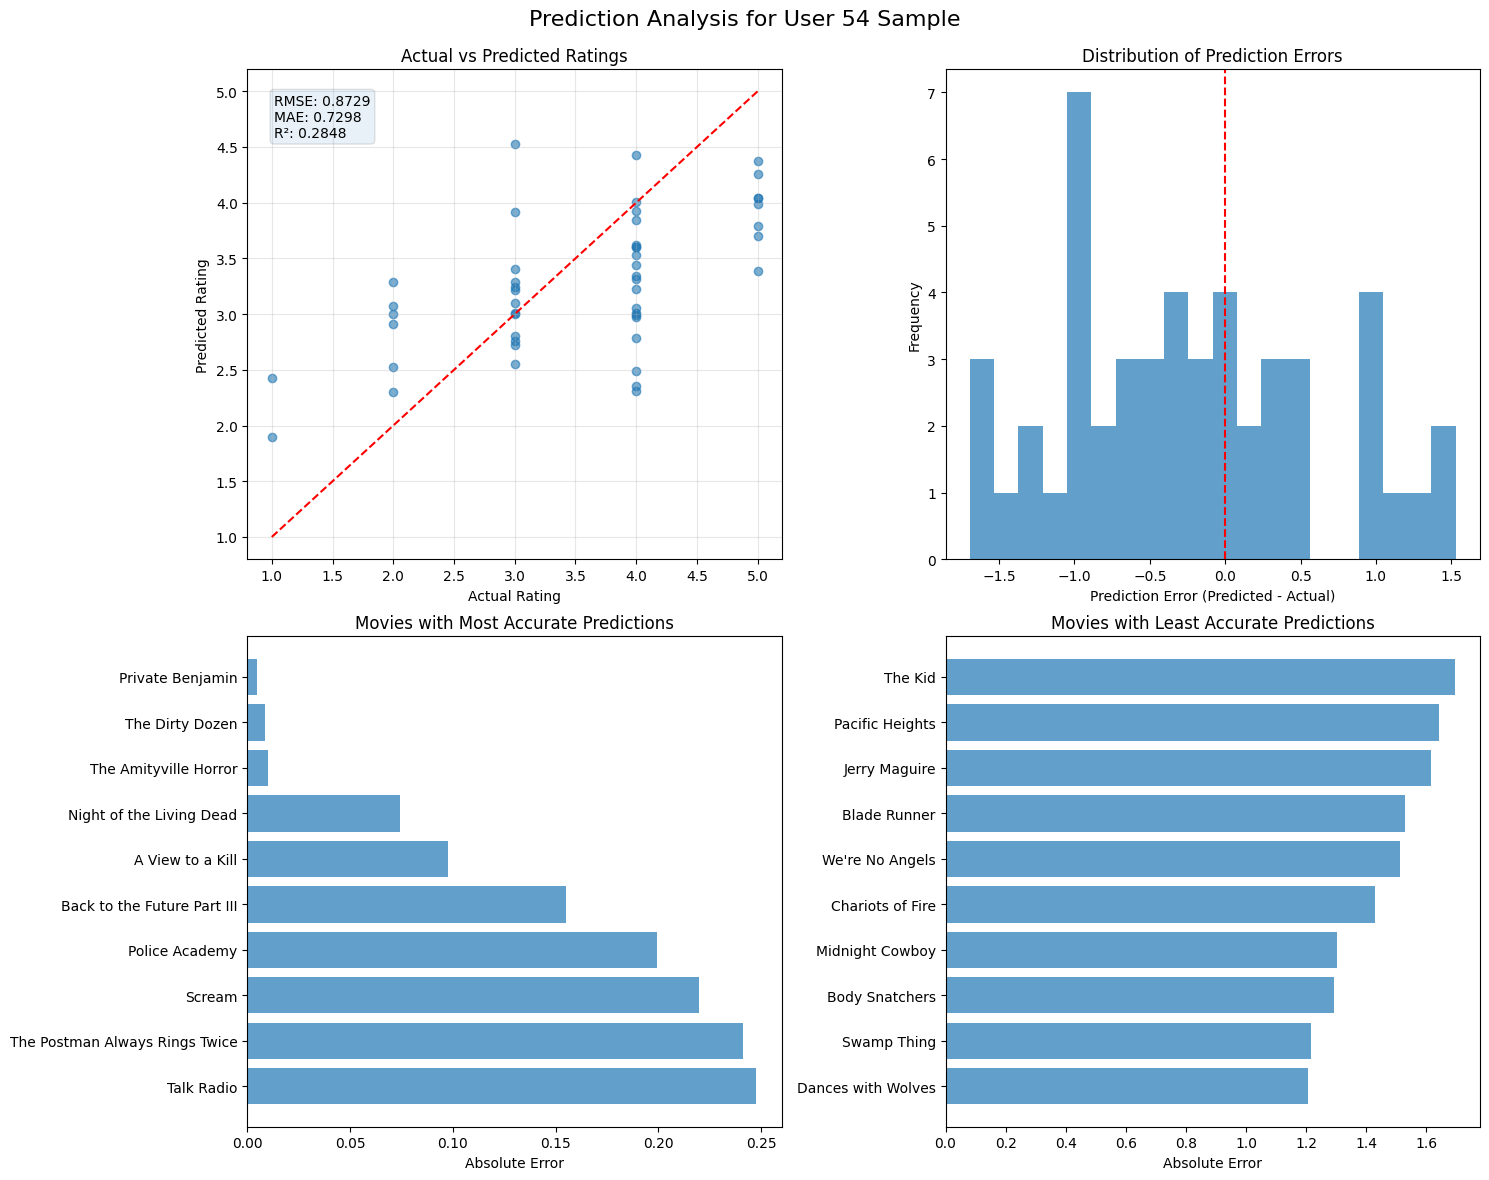


Most Accurate Predictions:
1. Private Benjamin - Actual: 3.0, Predicted: 3.00, Error: 0.00
2. The Dirty Dozen - Actual: 4.0, Predicted: 4.01, Error: 0.01
3. The Amityville Horror - Actual: 3.0, Predicted: 3.01, Error: 0.01
4. Night of the Living Dead - Actual: 4.0, Predicted: 3.93, Error: -0.07
5. A View to a Kill - Actual: 3.0, Predicted: 3.10, Error: 0.10

Least Accurate Predictions:
1. The Kid - Actual: 4.0, Predicted: 2.31, Error: -1.69
2. Pacific Heights - Actual: 4.0, Predicted: 2.36, Error: -1.64
3. Jerry Maguire - Actual: 5.0, Predicted: 3.38, Error: -1.62
4. Blade Runner - Actual: 3.0, Predicted: 4.53, Error: 1.53
5. We're No Angels - Actual: 4.0, Predicted: 2.49, Error: -1.51


In [108]:
# Visualize the results
visualize_user_predictions(
    testing_actual_predicted_df_1, 
    metrics_testing_1, 
    user_id=54, 
    set_name="Sample"
)

In [109]:
# II PROPOSE top N recommendations for a given user

In [112]:
def get_recommendations_for_user_without_y_scaling(user_id, model, user_features_df, item_features_df, 
                                user_scaler, item_scaler, df_movies=None, 
                                exclude_rated=True, ratings_df=None, top_n=10):
    """
    Generate top-N movie recommendations for a specific user.
    
    Parameters:
    -----------
    user_id : int
        ID of the user to generate recommendations for
    model : tf.keras.Model
        Trained recommendation model
    user_features_df : DataFrame
        DataFrame with userId and user features
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    user_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize user features during training
    item_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize movie features during training
    df_movies : DataFrame, optional
        DataFrame with movie metadata (for adding titles, etc.)
    exclude_rated : bool, default=True
        Whether to exclude movies the user has already rated
    ratings_df : DataFrame, optional
        DataFrame with user ratings (required if exclude_rated=True)
    top_n : int, default=10
        Number of recommendations to return
        
    Returns:
    --------
    recommendations : DataFrame
        DataFrame with top movie recommendations and scores
    """
    # Check if user exists in the user features
    if user_id not in user_features_df['userId'].values:
        raise ValueError(f"User ID {user_id} not found in user features")
    
    # Get user features
    user_row = user_features_df[user_features_df['userId'] == user_id]
    user_features = user_row.drop('userId', axis=1).values
    
    # Scale user features
    user_features_scaled = user_scaler.transform(user_features)
    
    # Get movie IDs and features
    movie_ids = item_features_df['movieId'].values
    movie_features = item_features_df.drop('movieId', axis=1).values
    
    # Scale movie features
    movie_features_scaled = item_scaler.transform(movie_features)
    
    # Prepare for batch prediction
    user_features_batch = np.repeat(user_features_scaled, len(movie_ids), axis=0)
    
    # Predict scores
    print(f"Predicting scores for {len(movie_ids)} movies...")
    scores = model.predict([user_features_batch, movie_features_scaled], verbose=0)
    
    # Create recommendations DataFrame
    recommendations = pd.DataFrame({
        'movieId': movie_ids,
        'score': scores.flatten()
    })
    
    # Exclude movies the user has already rated
    if exclude_rated and ratings_df is not None:
        user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
        print(f"Excluding {len(user_rated_movies)} already rated movies")
        recommendations = recommendations[~recommendations['movieId'].isin(user_rated_movies)]
    
    # Sort by score and get top N
    recommendations = recommendations.sort_values('score', ascending=False).head(top_n)
    
    # Add movie metadata if available
    if df_movies is not None:
        # Determine which columns to include from df_movies
        movie_info_cols = ['movieId']
        for col in ['title', 'genres', 'averageRating', 'startYear']:
            if col in df_movies.columns:
                movie_info_cols.append(col)
        
        # Merge with movie metadata
        recommendations = recommendations.merge(
            df_movies[movie_info_cols], 
            on='movieId', 
            how='left'
        )
    
    return recommendations


In [113]:
def get_recommendations_for_user(user_id, model, user_features_df, item_features_df, 
                                user_scaler, item_scaler, y_scaler=None, 
                                df_movies=None, exclude_rated=True, 
                                ratings_df=None, top_n=10,
                                train_indices=None):
    """
    Generate top-N movie recommendations for a specific user.
    Excluding if appropriate the movies the user has already rated
    Parameters:
    -----------
    user_id : int
        ID of the user to generate recommendations for
    model : tf.keras.Model
        Trained recommendation model
    user_features_df : DataFrame
        DataFrame with userId and user features
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    user_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize user features during training
    item_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize movie features during training
    y_scaler : sklearn.preprocessing.StandardScaler, optional
        Scaler used to normalize target values during training
    df_movies : DataFrame, optional
        DataFrame with movie metadata (for adding titles, etc.)
    exclude_rated : bool, default=True
        Whether to exclude movies the user has already rated
    ratings_df : DataFrame, optional
        DataFrame with user ratings (required if exclude_rated=True)
    top_n : int, default=10
        Number of recommendations to return
    train_indices : array-like, optional
        Indices of ratings used for training (to exclude from recommendations)
        
    Returns:
    --------
    recommendations : DataFrame
        DataFrame with top movie recommendations and scores
    """
    # Check if user exists in the user features
    if user_id not in user_features_df['userId'].values:
        raise ValueError(f"User ID {user_id} not found in user features")
    
    # Get user features
    user_row = user_features_df[user_features_df['userId'] == user_id]
    user_features = user_row.drop('userId', axis=1).values
    
    # Scale user features
    user_features_scaled = user_scaler.transform(user_features)
    
    # Get movie IDs and features
    movie_ids = item_features_df['movieId'].values
    movie_features = item_features_df.drop('movieId', axis=1).values
    
    # Scale movie features
    movie_features_scaled = item_scaler.transform(movie_features)
    
    # Prepare for batch prediction
    user_features_batch = np.repeat(user_features_scaled, len(movie_ids), axis=0)
    
    # Predict scores
    print(f"Predicting scores for {len(movie_ids)} movies...")
    scores_scaled = model.predict([user_features_batch, movie_features_scaled], verbose=0)
    
    # Inverse transform scores if a target scaler was used
    if y_scaler is not None:
        scores = y_scaler.inverse_transform(scores_scaled)
    else:
        scores = scores_scaled
    
    # Create recommendations DataFrame
    recommendations = pd.DataFrame({
        'movieId': movie_ids,
        'score': scores.flatten()
    })
    
    # Exclude movies the user has already rated
    if exclude_rated and ratings_df is not None:
        # Get all movies rated by this user
        user_rated_movies = ratings_df[ratings_df['userId'] == user_id]['movieId'].unique()
        print(f"Excluding {len(user_rated_movies)} already rated movies")
        recommendations = recommendations[~recommendations['movieId'].isin(user_rated_movies)]
    
    # Alternatively, exclude only training ratings if train_indices are provided
    elif train_indices is not None and ratings_df is not None:
        # Get training ratings for this user
        user_train_ratings = ratings_df.iloc[train_indices]
        user_train_movies = user_train_ratings[user_train_ratings['userId'] == user_id]['movieId'].unique()
        print(f"Excluding {len(user_train_movies)} movies from training set")
        recommendations = recommendations[~recommendations['movieId'].isin(user_train_movies)]
    
    # Sort by score and get top N
    recommendations = recommendations.sort_values('score', ascending=False).head(top_n)
    
    # Add movie metadata if available
    if df_movies is not None:
        # Determine which columns to include from df_movies
        movie_info_cols = ['movieId']
        for col in ['primaryTitle', 'genres', 'averageRating', 'startYear']:
            if col in df_movies.columns:
                movie_info_cols.append(col)
        
        # Merge with movie metadata
        recommendations = recommendations.merge(
            df_movies[movie_info_cols], 
            on='movieId', 
            how='left'
        )
    
    return recommendations


In [114]:
df_movieB.head()

,movieId,tconst,primaryTitle,originalTitle,startYear,runtimeMinutes,genres,directors,writers,averageRating,...,Musical,Mystery,News,Romance,Sci-Fi,Sport,Thriller,War,Western,\N
0,1,tt0114709,Toy Story,Toy Story,1995,81,"Adventure,Animation,Comedy",nm0005124,"nm0005124,nm0230032,nm0004056,nm0710020,nm0923...",8.3,...,0,0,0,0,0,0,0,0,0,0
1,2,tt0113497,Jumanji,Jumanji,1995,104,"Adventure,Comedy,Family",nm0002653,"nm0378144,nm0852430,nm0833164,nm0885575",7.1,...,0,0,0,0,0,0,0,0,0,0
2,3,tt0113228,Grumpier Old Men,Grumpier Old Men,1995,101,"Comedy,Romance",nm0222043,nm0425756,6.7,...,0,0,0,1,0,0,0,0,0,0
3,4,tt0114885,Waiting to Exhale,Waiting to Exhale,1995,124,"Comedy,Drama,Romance",nm0001845,"nm0573334,nm0060103",6.0,...,0,0,0,1,0,0,0,0,0,0
4,5,tt0113041,Father of the Bride Part II,Father of the Bride Part II,1995,106,"Comedy,Family,Romance",nm0796124,"nm0352443,nm0329304,nm0583600,nm0796124",6.1,...,0,0,0,1,0,0,0,0,0,0


In [116]:
user_id = 54  # Example user ID

In [117]:
recommendations_user54 = get_recommendations_for_user(
    user_id=user_id,
    model=model_basis,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,  # Include the target scaler
    df_movies=df_movieB,
    exclude_rated=False,  # Set to False if using train_indices
    ratings_df=mv_ratings,
    top_n=10,
    train_indices=None  # Include train indices to exclude training movies
)

Predicting scores for 22645 movies...


In [118]:
recommendations_user54

,movieId,score,primaryTitle,genres,averageRating,startYear
0,41831,4.7,They Died with Their Boots On,"War,Western",7.2,1941
1,8235,4.6,Safety Last!,"Action,Comedy,Thriller",8.1,1923
2,84508,4.6,The Raid,"War,Western",6.8,1954
3,79132,4.6,Inception,"Action,Adventure,Sci-Fi",8.8,2010
4,589,4.6,Terminator 2: Judgment Day,"Action,Adventure,Sci-Fi",8.6,1991
5,4404,4.6,Faust,"Drama,Fantasy,Horror",8.1,1926
6,3022,4.6,The General,"Action,Adventure,Comedy",8.1,1926
7,34435,4.6,Sholay,"Action,Adventure,Comedy",8.1,1975
8,89745,4.6,The Avengers,"Action,Sci-Fi",8.0,2012
9,1200,4.5,Aliens,"Action,Adventure,Sci-Fi",8.4,1986


In [119]:
#Check firms rated by this user user_id, 

In [120]:
def get_user_rated_movies(user_id, ratings_df, movies_df, min_rating=None, max_movies=None):
    """
    Get movies rated by a specific user, sorted by rating in descending order.
    
    Parameters:
    -----------
    user_id : int
        ID of the user
    ratings_df : DataFrame
        DataFrame containing user ratings with columns 'userId', 'movieId', 'rating'
    movies_df : DataFrame
        DataFrame containing movie information with at least 'movieId' and 'title' columns
    min_rating : float, optional
        Minimum rating threshold to include (e.g., 3.5 to show only positively rated movies)
    max_movies : int, optional
        Maximum number of movies to return
        
    Returns:
    --------
    user_movies : DataFrame
        DataFrame with the user's rated movies, sorted by rating in descending order
    """
    # Check if user exists in the ratings
    if user_id not in ratings_df['userId'].values:
        print(f"User {user_id} has not rated any movies in the dataset.")
        return pd.DataFrame()
    
    # Get all ratings by this user
    user_ratings = ratings_df[ratings_df['userId'] == user_id].copy()
    
    # Apply minimum rating filter if specified
    if min_rating is not None:
        user_ratings = user_ratings[user_ratings['rating'] >= min_rating]
        
    # Sort by rating in descending order
    user_ratings = user_ratings.sort_values('rating', ascending=False)
    
    # Apply maximum movies limit if specified
    if max_movies is not None:
        user_ratings = user_ratings.head(max_movies)
    
    # Merge with movie information
    required_cols = ['movieId']
    optional_cols = ['primaryTitle', 'genres', 'startYear', 'averageRating']
    
    # Add available optional columns
    movie_cols = required_cols + [col for col in optional_cols if col in movies_df.columns]
    
    # Merge ratings with movie details
    user_movies = user_ratings.merge(
        movies_df[movie_cols],
        on='movieId',
        how='left'
    )
    
    return user_movies


In [121]:
user_54 = get_user_rated_movies(user_id=54, ratings_df = mv_ratings, movies_df = df_movieB, min_rating=None, max_movies=20)

In [122]:
user_54

,userId,movieId,rating,timestamp,primaryTitle,genres,startYear,averageRating
0,54,1089,5.0,974837760,Reservoir Dogs,"Crime,Thriller",1992,8.3
1,54,1242,5.0,975441226,Glory,"Biography,Drama,History",1989,7.8
2,54,36,5.0,974836757,Dead Man Walking,"Crime,Drama",1995,7.5
3,54,1097,5.0,974836549,E.T. the Extra-Terrestrial,"Adventure,Family,Sci-Fi",1982,7.9
4,54,1124,5.0,975442096,On Golden Pond,Drama,1981,7.6
5,54,11,5.0,974840528,The American President,"Comedy,Drama,Romance",1995,6.8
6,54,3114,5.0,974840324,Toy Story 2,"Adventure,Animation,Comedy",1999,7.9
7,54,589,5.0,974837760,Terminator 2: Judgment Day,"Action,Adventure,Sci-Fi",1991,8.6
8,54,3006,5.0,974836757,The Insider,"Biography,Drama,History",1999,7.8
9,54,590,5.0,974837227,Dances with Wolves,"Adventure,Drama,Western",1990,8.0


In [124]:
user_id

54

In [126]:
def compare_ratings_with_recommendations_vectorized(user_id, model, user_features_df, item_features_df,
                                                  user_scaler, item_scaler, y_scaler,
                                                  ratings_df, movies_df, top_n=10):
    """
    Compare a user's actual ratings with model recommendations using vectorized operations.
    
    This helps evaluate how well the model captures the user's preferences.
    
    Parameters:
    -----------
    user_id : int
        ID of the user
    model : tf.keras.Model
        Trained recommendation model
    user_features_df : DataFrame
        DataFrame with userId and user features
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    user_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize user features during training
    item_scaler : sklearn.preprocessing.StandardScaler
        Scaler used to normalize movie features during training
    y_scaler : sklearn.preprocessing.StandardScaler, optional
        Scaler used to normalize target values during training
    ratings_df : DataFrame
        DataFrame containing user ratings
    movies_df : DataFrame
        DataFrame containing movie information
    top_n : int, default=10
        Number of recommendations to analyze
    """
    # Get the user's top-rated movies (vectorized)
    user_ratings = ratings_df[ratings_df['userId'] == user_id]
    
    if user_ratings.empty:
        print(f"User {user_id} has not rated any movies in the dataset.")
        return
    
    # Get highly rated movies (4+ stars)
    user_top_movies = user_ratings[user_ratings['rating'] >= 4.0].sort_values('rating', ascending=False)
    
    # Merge with movie information - include primaryTitle if available
    movie_cols = ['movieId']
    for col in ['title', 'primaryTitle', 'genres', 'startYear', 'averageRating']:
        if col in movies_df.columns:
            movie_cols.append(col)
    
    user_top_movies = user_top_movies.merge(movies_df[movie_cols], on='movieId', how='left')
    
    # Limit to top 10 for display
    user_top_movies = user_top_movies.head(10)
    
    # Get model recommendations (vectorized)
    # Get user features
    user_row = user_features_df[user_features_df['userId'] == user_id]
    user_features = user_row.drop('userId', axis=1).values
    
    # Scale user features
    user_features_scaled = user_scaler.transform(user_features)
    
    # Get movie IDs and features
    movie_ids = item_features_df['movieId'].values
    movie_features = item_features_df.drop('movieId', axis=1).values
    
    # Scale movie features
    movie_features_scaled = item_scaler.transform(movie_features)
    
    # Prepare for batch prediction
    user_features_batch = np.repeat(user_features_scaled, len(movie_ids), axis=0)
    
    # Predict scores
    scores_scaled = model.predict([user_features_batch, movie_features_scaled], verbose=0)
    
    # Inverse transform scores if a target scaler was used
    if y_scaler is not None:
        scores = y_scaler.inverse_transform(scores_scaled)
    else:
        scores = scores_scaled
    
    # Create recommendations DataFrame
    recommendations = pd.DataFrame({
        'movieId': movie_ids,
        'score': scores.flatten()
    })
    
    # Exclude movies the user has already rated
    rated_movies = user_ratings['movieId'].values
    recommendations = recommendations[~recommendations['movieId'].isin(rated_movies)]
    
    # Sort by score and get top N
    recommendations = recommendations.sort_values('score', ascending=False).head(top_n)
    
    # Add movie metadata
    recommendations = recommendations.merge(movies_df[movie_cols], on='movieId', how='left')
    
    # Display user's top-rated movies
    print("\n===== USER'S TOP-RATED MOVIES =====")
    if not user_top_movies.empty:
        for i, (_, movie) in enumerate(user_top_movies.iterrows(), 1):
            # Determine which title to use (primaryTitle preferred if available)
            if 'primaryTitle' in movie and pd.notna(movie['primaryTitle']):
                movie_title = movie['primaryTitle']
            elif 'title' in movie and pd.notna(movie['title']):
                movie_title = movie['title']
            else:
                movie_title = f"Movie {movie['movieId']}"
            
            # Display year if available
            year_str = f" ({movie['startYear']})" if 'startYear' in movie and pd.notna(movie['startYear']) else ""
            
            print(f"{i}. {movie_title}{year_str} - Rating: {movie['rating']:.1f}")
            
            # Display genres if available
            if 'genres' in movie and pd.notna(movie['genres']):
                print(f"   Genres: {movie['genres']}")
    else:
        print("No highly-rated movies found for this user.")
    
    # Display model recommendations
    print("\n===== MODEL RECOMMENDATIONS =====")
    for i, (_, movie) in enumerate(recommendations.iterrows(), 1):
        # Determine which title to use (primaryTitle preferred if available)
        if 'primaryTitle' in movie and pd.notna(movie['primaryTitle']):
            movie_title = movie['primaryTitle']
        elif 'title' in movie and pd.notna(movie['title']):
            movie_title = movie['title']
        else:
            movie_title = f"Movie {movie['movieId']}"
        
        # Display year if available
        year_str = f" ({movie['startYear']})" if 'startYear' in movie and pd.notna(movie['startYear']) else ""
        
        print(f"{i}. {movie_title}{year_str} - Score: {movie['score']:.4f}")
        
        # Display genres if available
        if 'genres' in movie and pd.notna(movie['genres']):
            print(f"   Genres: {movie['genres']}")
    
    # Analyze genre preferences (vectorized)
    if 'genres' in movies_df.columns:
        print("\n===== GENRE ANALYSIS =====")
        
        # Function to extract and count genres
        def extract_genres(df):
            # Combine all genres into a single list
            all_genres = []
            
            # Filter out NaN values and use vectorized string operations
            valid_genres = df['genres'].dropna()
            
            if not valid_genres.empty:
                # Split each genre string and flatten the result
                genre_lists = valid_genres.str.split('|')
                all_genres = [genre for sublist in genre_lists for genre in sublist if isinstance(sublist, list)]
            
            # Count frequencies
            return pd.Series(all_genres).value_counts()
        
        # Get genre counts
        user_genre_counts = extract_genres(user_top_movies)
        rec_genre_counts = extract_genres(recommendations)
        
        print("Top genres in user's highly-rated movies:")
        print(user_genre_counts.head(5))
        
        print("\nTop genres in recommendations:")
        print(rec_genre_counts.head(5))
        
        # Calculate genre overlap (Jaccard similarity)
        if not user_genre_counts.empty and not rec_genre_counts.empty:
            user_genres_set = set(user_genre_counts.index)
            rec_genres_set = set(rec_genre_counts.index)
            
            overlap = user_genres_set.intersection(rec_genres_set)
            union = user_genres_set.union(rec_genres_set)
            
            jaccard_similarity = len(overlap) / len(union) if union else 0
            
            print(f"\nGenre overlap (Jaccard similarity): {jaccard_similarity:.2f}")
            print(f"Common genres: {', '.join(overlap)}")
    
    # Return the data for further analysis if needed
    return {
        'user_top_movies': user_top_movies,
        'recommendations': recommendations
    }


In [127]:
results_54bis = compare_ratings_with_recommendations_vectorized(
    user_id=user_id,
    model=model_basis,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)


===== USER'S TOP-RATED MOVIES =====
1. Planes, Trains & Automobiles (1987.0) - Rating: 5.0
   Genres: Comedy,Drama
2. The Time Machine (1960.0) - Rating: 5.0
   Genres: Adventure,Romance,Sci-Fi
3. The Contender (2000.0) - Rating: 5.0
   Genres: Drama,Thriller
4. The American President (1995.0) - Rating: 5.0
   Genres: Comedy,Drama,Romance
5. 12 Monkeys (1995.0) - Rating: 5.0
   Genres: Mystery,Sci-Fi,Thriller
6. Dead Man Walking (1995.0) - Rating: 5.0
   Genres: Crime,Drama
7. Blazing Saddles (1974.0) - Rating: 5.0
   Genres: Comedy,Western
8. Predator (1987.0) - Rating: 5.0
   Genres: Action,Adventure,Horror
9. Parenthood (1989.0) - Rating: 5.0
   Genres: Comedy,Drama
10. Jurassic Park (1993.0) - Rating: 5.0
   Genres: Action,Adventure,Sci-Fi

===== MODEL RECOMMENDATIONS =====
1. They Died with Their Boots On (1941) - Score: 4.6505
   Genres: War,Western
2. Safety Last! (1923) - Score: 4.6476
   Genres: Action,Comedy,Thriller
3. The Raid (1954) - Score: 4.6450
   Genres: War,Western


In [128]:
#III FIND SIMILAR ITEMS*
# for a film just seen/searched/on which a positive critique was posted by a user, propose a list of similar films based on the NN model

In [129]:
def find_similar_movies(movie_id, item_features_df, movies_df, top_n=10, 
                       similarity_metric='cosine', exclude_same=True):
    """
    Find movies similar to a given movie based on their feature vectors.
    
    Parameters:
    -----------
    movie_id : int
        ID of the reference movie
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    movies_df : DataFrame
        DataFrame containing movie metadata
    top_n : int, default=10
        Number of similar movies to return
    similarity_metric : str, default='cosine'
        Similarity metric to use ('cosine', 'euclidean', or 'correlation')
    exclude_same : bool, default=True
        Whether to exclude the reference movie from results
        
    Returns:
    --------
    similar_movies : DataFrame
        DataFrame with similar movies and their similarity scores
    """
    from scipy.spatial.distance import cdist
    from scipy.stats import pearsonr
    
    # Check if movie exists
    if movie_id not in item_features_df['movieId'].values:
        print(f"Movie ID {movie_id} not found in the dataset.")
        return pd.DataFrame()
    
    # Get the movie's feature vector
    movie_idx = item_features_df[item_features_df['movieId'] == movie_id].index[0]
    movie_features = item_features_df.drop('movieId', axis=1).iloc[movie_idx].values.reshape(1, -1)
    
    # Get all movie features
    all_movie_features = item_features_df.drop('movieId', axis=1).values
    all_movie_ids = item_features_df['movieId'].values
    
    # Calculate similarities based on the chosen metric
    if similarity_metric == 'cosine':
        # Cosine similarity: 1 - cosine distance (higher is more similar)
        distances = cdist(movie_features, all_movie_features, 'cosine')[0]
        similarities = 1 - distances
    elif similarity_metric == 'euclidean':
        # Euclidean distance (lower is more similar)
        distances = cdist(movie_features, all_movie_features, 'euclidean')[0]
        # Convert to similarity (invert and normalize)
        max_dist = np.max(distances)
        similarities = 1 - (distances / max_dist)
    elif similarity_metric == 'correlation':
        # Pearson correlation (higher is more similar)
        similarities = np.array([
            pearsonr(movie_features[0], all_movie_features[i])[0] 
            for i in range(len(all_movie_features))
        ])
        # Handle NaN values (can occur if a vector has no variance)
        similarities = np.nan_to_num(similarities, nan=0.0)
    else:
        raise ValueError("similarity_metric must be 'cosine', 'euclidean', or 'correlation'")
    
    # Create DataFrame with movie IDs and similarity scores
    similar_movies = pd.DataFrame({
        'movieId': all_movie_ids,
        'similarity': similarities
    })
    
    # Exclude the reference movie if requested
    if exclude_same:
        similar_movies = similar_movies[similar_movies['movieId'] != movie_id]
    
    # Sort by similarity (descending) and get top N
    similar_movies = similar_movies.sort_values('similarity', ascending=False).head(top_n)
    
    # Add movie metadata
    movie_cols = ['movieId']
    for col in ['title', 'primaryTitle', 'genres', 'startYear', 'averageRating']:
        if col in movies_df.columns:
            movie_cols.append(col)
    
    similar_movies = similar_movies.merge(movies_df[movie_cols], on='movieId', how='left')
    
    return similar_movies


In [ ]:
def display_similar_movies(movie_id, item_features_df, movies_df, top_n=10, 
                          similarity_metric='cosine', exclude_same=True):
    """
    Find and display movies similar to a given movie based on their feature vectors.
    
    Parameters:
    -----------
    movie_id : int
        ID of the reference movie
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    movies_df : DataFrame
        DataFrame containing movie metadata
    top_n : int, default=10
        Number of similar movies to return
    similarity_metric : str, default='cosine'
        Similarity metric to use ('cosine', 'euclidean', or 'correlation')
    exclude_same : bool, default=True
        Whether to exclude the reference movie from results
    """
    # Get similar movies
    similar_movies = find_similar_movies(
        movie_id=movie_id,
        item_features_df=item_features_df,
        movies_df=movies_df,
        top_n=top_n,
        similarity_metric=similarity_metric,
        exclude_same=exclude_same
    )
    
    if similar_movies.empty:
        return
    
    # Get reference movie details
    ref_movie = movies_df[movies_df['movieId'] == movie_id].iloc[0]
    
    # Determine which title to use for reference movie
    if 'primaryTitle' in ref_movie and pd.notna(ref_movie['primaryTitle']):
        ref_title = ref_movie['primaryTitle']
    elif 'title' in ref_movie and pd.notna(ref_movie['title']):
        ref_title = ref_movie['title']
    else:
        ref_title = f"Movie {movie_id}"
    
    # Display year if available
    year_str = f" ({ref_movie['startYear']})" if 'startYear' in ref_movie and pd.notna(ref_movie['startYear']) else ""
    
    # Display genres if available
    genres_str = f"\nGenres: {ref_movie['genres']}" if 'genres' in ref_movie and pd.notna(ref_movie['genres']) else ""
    
    # Display rating if available
    rating_str = f"\nRating: {ref_movie['averageRating']:.1f}" if 'averageRating' in ref_movie and pd.notna(ref_movie['averageRating']) else ""
    
    # Print header
    print(f"\n===== Movies Similar to: {ref_title}{year_str} =====")
    print(f"Movie ID: {movie_id}{genres_str}{rating_str}")
    print(f"Similarity Metric: {similarity_metric}")
    print("\nTop Similar Movies:")
    
    # Print each similar movie
    for i, (_, movie) in enumerate(similar_movies.iterrows(), 1):
        # Determine which title to use
        if 'primaryTitle' in movie and pd.notna(movie['primaryTitle']):
            movie_title = movie['primaryTitle']
        elif 'title' in movie and pd.notna(movie['title']):
            movie_title = movie['title']
        else:
            movie_title = f"Movie {movie['movieId']}"
        
        # Display year if available
        year_str = f" ({movie['startYear']})" if 'startYear' in movie and pd.notna(movie['startYear']) else ""
        
        # Format similarity score
        similarity_str = f"{movie['similarity']:.4f}"
        
        print(f"{i}. {movie_title}{year_str} - Similarity: {similarity_str}")
        
        # Display genres if available
        if 'genres' in movie and pd.notna(movie['genres']):
            print(f"   Genres: {movie['genres']}")
        
        # Display rating if available
        if 'averageRating' in movie and pd.notna(movie['averageRating']):
            print(f"   Rating: {movie['averageRating']:.1f}")
        
        print()
    
    # Return the DataFrame for further analysis
    return similar_movies


In [131]:
movie_id = 1580

In [132]:
# Using cosine similarity (default)
similar_movies_cosine_1580 = display_similar_movies(
    movie_id=movie_id,
    item_features_df=item_features_df,
    movies_df=df_movieB,
    top_n=10,
    similarity_metric='cosine'
)


===== Movies Similar to: Men in Black (1997) =====
Movie ID: 1580
Genres: Action,Adventure,Comedy
Rating: 7.3
Similarity Metric: cosine

Top Similar Movies:
1. The Gamers: Dorkness Rising (2008) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

2. The In-Laws (1979) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

3. Samurai Fiction (1998) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

4. Big Trouble in Little China (1986) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

5. The Way of the Dragon (1972) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

6. Project A (1983) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

7. Armour of God 2: Operation Condor (1991) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

8. The Great Race (1965) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

9. The Good the Bad t

In [133]:
# Using correlation similarity
similar_movies_corr_1580 = display_similar_movies(
    movie_id=movie_id,
    item_features_df=item_features_df,
    movies_df=df_movieB,
    top_n=10,
    similarity_metric='correlation'
)


===== Movies Similar to: Men in Black (1997) =====
Movie ID: 1580
Genres: Action,Adventure,Comedy
Rating: 7.3
Similarity Metric: correlation

Top Similar Movies:
1. The Gamers: Dorkness Rising (2008) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

2. The In-Laws (1979) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

3. Armour of God 2: Operation Condor (1991) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

4. The Good the Bad the Weird (2008) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

5. Big Trouble in Little China (1986) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

6. The Great Race (1965) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

7. Project A (1983) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

8. The Way of the Dragon (1972) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

9. Th

In [134]:
def find_similar_movies_with_explanation(movie_id, item_features_df, movies_df, top_n=10, 
                                        similarity_metric='cosine', exclude_same=True,
                                        explain_top_features=3):
    """
    Find movies similar to a given movie and explain the similarity.
    
    Parameters:
    -----------
    movie_id : int
        ID of the reference movie
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    movies_df : DataFrame
        DataFrame containing movie metadata
    top_n : int, default=10
        Number of similar movies to return
    similarity_metric : str, default='cosine'
        Similarity metric to use ('cosine', 'euclidean', or 'correlation')
    exclude_same : bool, default=True
        Whether to exclude the reference movie from results
    explain_top_features : int, default=3
        Number of top contributing features to explain
        
    Returns:
    --------
    similar_movies : DataFrame
        DataFrame with similar movies, similarity scores, and explanations
    """
    # Get similar movies first
    similar_movies = find_similar_movies(
        movie_id=movie_id,
        item_features_df=item_features_df,
        movies_df=movies_df,
        top_n=top_n,
        similarity_metric=similarity_metric,
        exclude_same=exclude_same
    )
    
    if similar_movies.empty:
        return similar_movies
    
    # Get feature names
    feature_names = item_features_df.drop('movieId', axis=1).columns
    
    # Get reference movie features
    ref_movie_idx = item_features_df[item_features_df['movieId'] == movie_id].index[0]
    ref_features = item_features_df.drop('movieId', axis=1).iloc[ref_movie_idx].values
    
    # Add explanation for each similar movie
    explanations = []
    
    for _, row in similar_movies.iterrows():
        similar_movie_id = row['movieId']
        similar_movie_idx = item_features_df[item_features_df['movieId'] == similar_movie_id].index[0]
        similar_features = item_features_df.drop('movieId', axis=1).iloc[similar_movie_idx].values
        
        # Calculate feature-wise contribution to similarity
        if similarity_metric == 'cosine':
            # For cosine, we look at the product of normalized features
            norm_ref = np.linalg.norm(ref_features)
            norm_similar = np.linalg.norm(similar_features)
            
            if norm_ref > 0 and norm_similar > 0:
                contributions = (ref_features / norm_ref) * (similar_features / norm_similar)
            else:
                contributions = np.zeros_like(ref_features)
                
        elif similarity_metric == 'euclidean':
            # For euclidean, smaller differences contribute more to similarity
            differences = np.abs(ref_features - similar_features)
            max_diff = np.max(differences) if np.max(differences) > 0 else 1
            contributions = 1 - (differences / max_diff)
            
        elif similarity_metric == 'correlation':
            # For correlation, we look at how features deviate from their means together
            ref_centered = ref_features - np.mean(ref_features)
            similar_centered = similar_features - np.mean(similar_features)
            
            contributions = ref_centered * similar_centered
            
            # Normalize
            norm = np.linalg.norm(ref_centered) * np.linalg.norm(similar_centered)
            if norm > 0:
                contributions = contributions / norm
            
        # Get top contributing features
        feature_contributions = list(zip(feature_names, contributions))
        top_features = sorted(feature_contributions, key=lambda x: abs(x[1]), reverse=True)[:explain_top_features]
        
        # Format explanation
        explanation = ", ".join([f"{name} ({contrib:.3f})" for name, contrib in top_features])
        explanations.append(explanation)
    
    # Add explanations to the DataFrame
    similar_movies['top_features'] = explanations
    
    return similar_movies


In [135]:
def display_similar_movies_with_explanation(movie_id, item_features_df, movies_df, top_n=10, 
                                           similarity_metric='cosine', exclude_same=True,
                                           explain_top_features=3):
    """
    Find, explain, and display movies similar to a given movie.
    """
    # Get similar movies with explanations
    similar_movies = find_similar_movies_with_explanation(
        movie_id=movie_id,
        item_features_df=item_features_df,
        movies_df=movies_df,
        top_n=top_n,
        similarity_metric=similarity_metric,
        exclude_same=exclude_same,
        explain_top_features=explain_top_features
    )
    
    if similar_movies.empty:
        return
    
    # Get reference movie details
    ref_movie = movies_df[movies_df['movieId'] == movie_id].iloc[0]
    
    # Determine which title to use for reference movie
    if 'primaryTitle' in ref_movie and pd.notna(ref_movie['primaryTitle']):
        ref_title = ref_movie['primaryTitle']
    elif 'title' in ref_movie and pd.notna(ref_movie['title']):
        ref_title = ref_movie['title']
    else:
        ref_title = f"Movie {movie_id}"
    
    # Print header
    print(f"\n===== Movies Similar to: {ref_title} =====")
    print(f"Similarity Metric: {similarity_metric}")
    print("\nTop Similar Movies:")
    
    # Print each similar movie with explanation
    for i, (_, movie) in enumerate(similar_movies.iterrows(), 1):
        # Determine which title to use
        if 'primaryTitle' in movie and pd.notna(movie['primaryTitle']):
            movie_title = movie['primaryTitle']
        elif 'title' in movie and pd.notna(movie['title']):
            movie_title = movie['title']
        else:
            movie_title = f"Movie {movie['movieId']}"
        
        # Display year if available
        year_str = f" ({movie['startYear']})" if 'startYear' in movie and pd.notna(movie['startYear']) else ""
        
        print(f"{i}. {movie_title}{year_str} - Similarity: {movie['similarity']:.4f}")
        
        # Display genres if available
        if 'genres' in movie and pd.notna(movie['genres']):
            print(f"   Genres: {movie['genres']}")
        
        # Display explanation
        print(f"   Similar because of: {movie['top_features']}")
        print()
    
    # Return the DataFrame for further analysis
    return similar_movies


In [136]:
similar_movies_explan_1580 = display_similar_movies_with_explanation(
    movie_id=movie_id,
    item_features_df=item_features_df,
    movies_df=df_movieB,
    top_n=10,
    similarity_metric='cosine',
    explain_top_features=5)


===== Movies Similar to: Men in Black =====
Similarity Metric: cosine

Top Similar Movies:
1. The Gamers: Dorkness Rising (2008) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Similar because of: averageRating (0.947), Action (0.018), Adventure (0.018), Comedy (0.018), Adult (0.000)

2. The In-Laws (1979) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Similar because of: averageRating (0.947), Action (0.018), Adventure (0.018), Comedy (0.018), Adult (0.000)

3. Samurai Fiction (1998) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Similar because of: averageRating (0.946), Action (0.018), Adventure (0.018), Comedy (0.018), Adult (0.000)

4. Big Trouble in Little China (1986) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Similar because of: averageRating (0.946), Action (0.018), Adventure (0.018), Comedy (0.018), Adult (0.000)

5. The Way of the Dragon (1972) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Similar because of: a

In [137]:
#checking model_basis for 32 num_outputs = 32

In [138]:
num_outputs = 32

In [139]:
model_basis32 = create_model_2NN_reco(num_outputs=32, num_item_features=num_item_features, num_user_features=num_user_features )

In [140]:
model_basis32.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_2        │ (None, 32)        │     43,168 │ input_layer_6[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_3        │ (None, 32)        │     43,680 │ input_layer_7[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 32)        │          0 │ sequential_2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 32)        │          0 │ sequential_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_1 (Dot)         │ (None, 1)         │          0 │ lambda_2[0][0],   │
│                     │                   │            │ lambda_3[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 86,848 (339.25 KB)

 Trainable params: 86,848 (339.25 KB)

 Non-trainable params: 0 (0.00 B)

In [141]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_basis32.compile(optimizer=opt,
              loss=cost_fn)


In [142]:
tf.random.set_seed(1)
#model.fit([user_train, item_train], y_train, epochs=30)
history_basis32 = model_basis32.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=40)


Epoch 1/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1688
Epoch 2/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1548
Epoch 3/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1519
Epoch 4/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1501
Epoch 5/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1488
Epoch 6/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1475
Epoch 7/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1461
Epoch 8/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1446
Epoch 9/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1434
Epoch 10/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1423
Epoch 11/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1414
Epoch 12/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1405
Epoch 13/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1395
Epoch 14/40
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1386
Epoch 15/40
1358/1358 ━━━━━━━

In [143]:
model_basis32.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1480


0.14572393894195557

In [144]:
#probably overfitting, comparing train loss : 0.1114 and test loss 0.1524 on 15/5/2025

#probably overfitting, comparing train loss : 0.1137 and test loss 0.1495 on 16/5/2025

In [145]:
#num_outputs = 32 #used in experiments up to & including v3


In [146]:
from tensorflow.keras.utils import plot_model
plot_model(model_basis, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [147]:
keras.utils.plot_model(model_basis, "my_first_model.png")


You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [148]:
#Experiment A Base model  AND early stopping

In [150]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [151]:
base_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',  # Changed from 'val_loss''val_loss', 
        patience=5, 
        restore_best_weights=True
    )
]

In [152]:
model_A = create_model_2NN_reco(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features )
#model_A = create_model_2NN_reco(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features )

In [153]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_A.compile(optimizer=opt,
              loss=cost_fn)

In [154]:
history_A = model_A.fit(
    [user_train_scaled, item_train_scaled], y_train_scaled,
    #train_dataset,
    #validation_data=val_dataset,
    callbacks=base_callbacks,
    epochs=100
)

Epoch 1/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.1697
Epoch 2/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1550
Epoch 3/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1525
Epoch 4/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1505
Epoch 5/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1490
Epoch 6/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1478
Epoch 7/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1468
Epoch 8/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1457
Epoch 9/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1442
Epoch 10/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1429
Epoch 11/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1420
Epoch 12/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1412
Epoch 13/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1403
Epoch 14/100
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1394
Epoch 15/100
13

In [155]:
model_A.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1506


0.14868555963039398

In [156]:
#Results when using model A 

In [157]:
#Experiment A2 Base model AND validation AND early stopping

In [158]:
base2_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Changed from 'val_loss''val_loss', 
        patience=5, 
        restore_best_weights=True
    )
]

In [159]:
model_A2 = create_model_2NN_reco(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features )

In [160]:
model_A2.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_15      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_6        │ (None, 64)        │     47,296 │ input_layer_14[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_7        │ (None, 64)        │     47,808 │ input_layer_15[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_6 (Lambda)   │ (None, 64)        │          0 │ sequential_6[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_7 (Lambda)   │ (None, 64)        │          0 │ sequential_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_3 (Dot)         │ (None, 1)         │          0 │ lambda_6[0][0],   │
│                     │                   │            │ lambda_7[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,104 (371.50 KB)

 Trainable params: 95,104 (371.50 KB)

 Non-trainable params: 0 (0.00 B)

In [161]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_A2.compile(optimizer=opt,
              loss=cost_fn)


In [162]:
history_A2 = model_A2.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=40, callbacks=base2_callbacks, validation_split=0.2)

Epoch 1/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.1664 - val_loss: 0.1567
Epoch 2/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1528 - val_loss: 0.1556
Epoch 3/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1498 - val_loss: 0.1542
Epoch 4/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1475 - val_loss: 0.1529
Epoch 5/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1457 - val_loss: 0.1521
Epoch 6/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1444 - val_loss: 0.1516
Epoch 7/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1435 - val_loss: 0.1512
Epoch 8/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1424 - val_loss: 0.1503
Epoch 9/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1411 - val_loss: 0.1490
Epoch 10/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1397 - val_loss: 0.1483
Epoch 11/40
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1385 - val_loss: 0.1478
Epoch 12/40
1087/1087 ━━━━━━━━

In [163]:
history_A2 

In [164]:
model_A2.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1467


0.14479082822799683

In [165]:
# function to display the evolution of the loss stored in the history object
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 0.3])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)

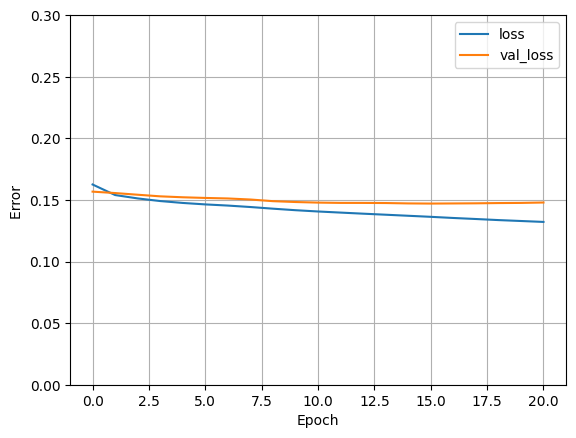

In [166]:
plot_loss(history_A2)

In [167]:
#Experiment B: adding dropout rate

In [168]:
def create_model_2NN_reco_B(num_outputs=64, num_item_features=None, num_user_features=None, 
                          dropout_rate=0.2, l2_reg=0.0):
    """
    Creates a dual-network model with dropout regularization and dot product output.
    
    Parameters:
    - num_outputs: Dimension of the embedding space
    - num_user_features: Number of user features
    - num_item_features: Number of item features
    - dropout_rate: Rate for dropout layers (0 to 1)
    - l2_reg: L2 regularization factor (optional)
    
    Returns:
    - A Keras Model
    """
    tf.random.set_seed(1)
    
    # Optional L2 regularizer
    regularizer = None
    if l2_reg > 0:
        regularizer = tf.keras.regularizers.l2(l2_reg)
    
    # Create the user network as a Sequential model
    user_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_user_features,)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate),  # Add dropout after first dense layer
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate),  # Add dropout after second dense layer
        tf.keras.layers.Dense(num_outputs, activation='linear', kernel_regularizer=regularizer)
    ])
    
    # Create the item network as a Sequential model
    item_model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=(num_item_features,)),
        tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate),  # Add dropout after first dense layer
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout_rate),  # Add dropout after second dense layer
        tf.keras.layers.Dense(num_outputs, activation='linear', kernel_regularizer=regularizer)
    ])
    
    # Create input layers for the functional API
    input_user = tf.keras.layers.Input(shape=(num_user_features,))
    input_item = tf.keras.layers.Input(shape=(num_item_features,))
    
    # Get embeddings from each network
    user_embedding = user_model(input_user)
    item_embedding = item_model(input_item)
    
    # Normalize embeddings
    user_embedding_norm = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1)
    )(user_embedding)
    
    item_embedding_norm = tf.keras.layers.Lambda(
        lambda x: tf.linalg.l2_normalize(x, axis=1)
    )(item_embedding)
    
    # Compute dot product
    dot_product = tf.keras.layers.Dot(axes=1)([user_embedding_norm, item_embedding_norm])
    
    # Create the full model
    model = tf.keras.Model(inputs=[input_user, input_item], outputs=dot_product)
    
    return model


In [169]:
model_B2 = create_model_2NN_reco_B(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features, dropout_rate=0.2)

In [170]:
model_B2.summary()

Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_8        │ (None, 64)        │     47,296 │ input_layer_18[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_9        │ (None, 64)        │     47,808 │ input_layer_19[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_8 (Lambda)   │ (None, 64)        │          0 │ sequential_8[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_9 (Lambda)   │ (None, 64)        │          0 │ sequential_9[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_4 (Dot)         │ (None, 1)         │          0 │ lambda_8[0][0],   │
│                     │                   │            │ lambda_9[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,104 (371.50 KB)

 Trainable params: 95,104 (371.50 KB)

 Non-trainable params: 0 (0.00 B)

In [171]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_B2.compile(optimizer=opt,
              loss=cost_fn)

In [172]:
tf.random.set_seed(1)
#model.fit([user_train, item_train], y_train, epochs=30)
#history_B2 = model_B2.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=40, callbacks=base2_callbacks, validation_split=0.2)
history_B2 = model_B2.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=100, callbacks=base2_callbacks, validation_split=0.2)


Epoch 1/100


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1682 - val_loss: 0.1564
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1540 - val_loss: 0.1564
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1518 - val_loss: 0.1560
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1499 - val_loss: 0.1543
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1481 - val_loss: 0.1535
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1476 - val_loss: 0.1521
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1463 - val_loss: 0.1515
Epoch 8/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1455 - val_loss: 0.1507
Epoch 9/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1436 - val_loss: 0.1497
Epoch 10/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1430 - val_loss: 0.1490
Epoch 11/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1421 - val_loss: 0.1487
Epoch 12/100
1087/1087 ━━━━━━━━

In [173]:
model_B2.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1447


0.1428399682044983

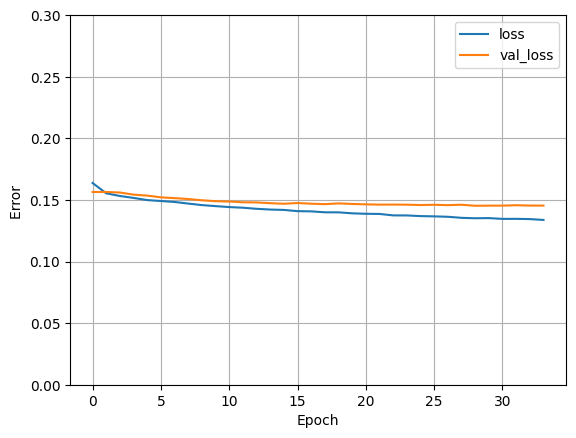

In [174]:
plot_loss(history_B2)

In [175]:
# Differences observed between history and history 2 NOTES 15 5 2025
#In the begining, I do model.fit with epochs=50. during training, the loss for epoch 1/50 is 0.1687, and for epoch 50/50 it is loss: 0.1207. And for model.evaluate my loss: 0.1480 
# Then I do tf.random.set_seed(1) model.fit with epochs=100, and I get for Epoch 1/100 loss: 0.1203 and for Epoch 100/100 loss: 0.1075. Then for model.evaluate I get loss: 0.1513. 
# What can be the cause of The difference in first epoch loss (0.1687 vs 0.1203) ?

#Worse Evaluation Loss in Second Run: 
#second run shows:
#   Better training loss (0.1075 vs 0.1207)
#   Worse evaluation loss (0.1513 vs 0.1480)
# sign of overfitting. Your model is:

#   Learning the training data too well
#   Losing generalization ability on unseen data


In [176]:
#checking validation_split within keras model.fit
# validation_data = ?? when using both item and user dimensions? 

In [177]:
# function to display the evolution of the loss stored in the history object
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 1.0])
    plt.xlabel('Epoch')
    plt.ylabel('Error ')
    plt.legend()
    plt.grid(True)



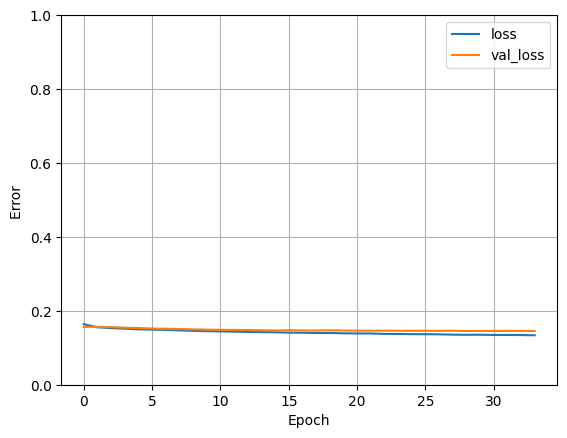

In [178]:
plot_loss(history_B2)

In [179]:
#Experiment B5, 19/5/2025 add dropout rate 0.5 to previously defined modelB (early stop via callbacks2, Early Stop & val_loss monitoring)

In [180]:
model_B5 = create_model_2NN_reco_B(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features, dropout_rate=0.5, l2_reg=0.0)

In [181]:
model_B5.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_10       │ (None, 64)        │     47,296 │ input_layer_22[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_11       │ (None, 64)        │     47,808 │ input_layer_23[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_10 (Lambda)  │ (None, 64)        │          0 │ sequential_10[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_11 (Lambda)  │ (None, 64)        │          0 │ sequential_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_5 (Dot)         │ (None, 1)         │          0 │ lambda_10[0][0],  │
│                     │                   │            │ lambda_11[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,104 (371.50 KB)

 Trainable params: 95,104 (371.50 KB)

 Non-trainable params: 0 (0.00 B)

In [182]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_B5.compile(optimizer=opt,
              loss=cost_fn)

In [183]:
history_B5 = model_B5.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=100, callbacks=base2_callbacks, validation_split=0.2)

Epoch 1/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.1731 - val_loss: 0.1581
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1591 - val_loss: 0.1572
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1563 - val_loss: 0.1547
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1545 - val_loss: 0.1543
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1530 - val_loss: 0.1525
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1515 - val_loss: 0.1523
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1503 - val_loss: 0.1519
Epoch 8/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1502 - val_loss: 0.1516
Epoch 9/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1495 - val_loss: 0.1511
Epoch 10/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1487 - val_loss: 0.1505
Epoch 11/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1484 - val_loss: 0.1502
Epoch 12/100
1087/1

In [184]:
model_B5.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1454


0.14293453097343445

In [185]:
#experiment C2  add l2_reg 0.001 to Dropout rate 0.2

In [186]:
model_C2_001 = create_model_2NN_reco_B(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features, dropout_rate=0.2, l2_reg=0.001)

In [187]:
model_C2_001.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_26      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_12       │ (None, 64)        │     47,296 │ input_layer_26[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_13       │ (None, 64)        │     47,808 │ input_layer_27[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_12 (Lambda)  │ (None, 64)        │          0 │ sequential_12[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_13 (Lambda)  │ (None, 64)        │          0 │ sequential_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_6 (Dot)         │ (None, 1)         │          0 │ lambda_12[0][0],  │
│                     │                   │            │ lambda_13[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,104 (371.50 KB)

 Trainable params: 95,104 (371.50 KB)

 Non-trainable params: 0 (0.00 B)

In [188]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_C2_001.compile(optimizer=opt,
              loss=cost_fn)

In [189]:
history_C2_001 = model_C2_001.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=100, callbacks=base2_callbacks, validation_split=0.2)

Epoch 1/100


1087/1087 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.2612 - val_loss: 0.1734
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1772 - val_loss: 0.1707
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.1771 - val_loss: 0.1704
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1753 - val_loss: 0.1707
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1748 - val_loss: 0.1703
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1759 - val_loss: 0.1712
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1754 - val_loss: 0.1713
Epoch 8/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1751 - val_loss: 0.1709
Epoch 9/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1750 - val_loss: 0.1703
Epoch 10/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1759 - val_loss: 0.1709


In [190]:
model_C2_001.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1704


0.1666269153356552

In [191]:
#NB having added the l2_reg = 0.001 has reduced performance (tst loss was prpeviously 0.1444)

In [192]:
#Experiment D Add learning rate scheduling

In [193]:
# Option : use ReduceLROnPlateau 
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,         # reduce by half
    patience=5,         # after 5 epochs without improvement
    min_lr=0.0001,
    verbose=1           # print when learning rate changes
)

In [194]:
# add to previous callbacks

In [195]:
base3_callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',  # Changed from 'val_loss''val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    reduce_lr
]

In [196]:
#build new model to add decresing learning rate

In [197]:
model_D2 = create_model_2NN_reco_B(num_outputs=64, num_item_features=num_item_features, num_user_features=num_user_features, dropout_rate=0.2, l2_reg=0.0)

In [198]:
model_D2.summary()

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_30      │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_31      │ (None, 25)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_14       │ (None, 64)        │     47,296 │ input_layer_30[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_15       │ (None, 64)        │     47,808 │ input_layer_31[0… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_14 (Lambda)  │ (None, 64)        │          0 │ sequential_14[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_15 (Lambda)  │ (None, 64)        │          0 │ sequential_15[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_7 (Dot)         │ (None, 1)         │          0 │ lambda_14[0][0],  │
│                     │                   │            │ lambda_15[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 95,104 (371.50 KB)

 Trainable params: 95,104 (371.50 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
tf.random.set_seed(1)
cost_fn = tf.keras.losses.MeanSquaredError()
opt = keras.optimizers.Adam(learning_rate=0.01)
model_D2.compile(optimizer=opt,
              loss=cost_fn)

In [200]:
history_D2 = model_D2.fit([user_train_scaled, item_train_scaled], y_train_scaled, epochs=100, callbacks=base3_callbacks, validation_split=0.2)

Epoch 1/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.1697 - val_loss: 0.1575 - learning_rate: 0.0100
Epoch 2/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1551 - val_loss: 0.1560 - learning_rate: 0.0100
Epoch 3/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1519 - val_loss: 0.1559 - learning_rate: 0.0100
Epoch 4/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1505 - val_loss: 0.1541 - learning_rate: 0.0100
Epoch 5/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1482 - val_loss: 0.1527 - learning_rate: 0.0100
Epoch 6/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1469 - val_loss: 0.1520 - learning_rate: 0.0100
Epoch 7/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1466 - val_loss: 0.1515 - learning_rate: 0.0100
Epoch 8/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1450 - val_loss: 0.1509 - learning_rate: 0.0100
Epoch 9/100
1087/1087 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1444 - val_loss: 0.1505 - learn

In [201]:
model_D2.evaluate([user_test_scaled, item_test_scaled], y_test_scaled)

340/340 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1441


0.14235606789588928

In [202]:
# IN ORDER TO GENERATE RECOMMENDATIONS WITH INVERSE TRANSFORMATION

In [204]:
# Example usage with scalers TO PUT THE RIGHTS OBJECTS!!! Dataframes etc!!!
user_id = 42  # Example user ID

# Get recommendations with inverse scaling
recommendations = get_recommendations_for_user(
    user_id=user_id,
    model=model_A2,
    user_features_df=user_features_df,  # Original unscaled features, corrected to user_features_df
    item_features_df=item_features_df,  # Original unscaled features, corrected to item_features_df
    user_scaler=user_scaler,                     # Scaler used during training
    item_scaler=movie_scaler,                     # Scaler used during training
    y_scaler=scalerTarget,                       # Target scaler , corrected to 
    df_movies=df_movieB,
    ratings_df=mv_ratings,
    exclude_rated=True,
    top_n=10
)

Predicting scores for 22645 movies...


Excluding 51 already rated movies


In [276]:
results_1 = compare_ratings_with_recommendations_vectorized(
    user_id=1,
    model=model_basis,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)



===== USER'S TOP-RATED MOVIES =====
1. The Lord of the Rings: The Two Towers (2002) - Rating: 5.0
   Genres: Adventure,Drama,Fantasy
2. The Lord of the Rings: The Fellowship of the Ring (2001) - Rating: 5.0
   Genres: Adventure,Drama,Fantasy
3. Freaks (1932) - Rating: 5.0
   Genres: Drama,Horror
4. The Lord of the Rings: The Return of the King (2003) - Rating: 5.0
   Genres: Adventure,Drama,Fantasy
5. Star Wars: Episode V - The Empire Strikes Back (1980) - Rating: 4.5
   Genres: Action,Adventure,Fantasy
6. Indiana Jones and the Raiders of the Lost Ark (1981) - Rating: 4.5
   Genres: Action,Adventure
7. Spider-Man 2 (2004) - Rating: 4.5
   Genres: Action,Adventure,Sci-Fi
8. Rob Roy (1995) - Rating: 4.0
   Genres: Adventure,Biography,Drama
9. Blade Runner (1982) - Rating: 4.0
   Genres: Action,Drama,Sci-Fi
10. The Shawshank Redemption (1994) - Rating: 4.0
   Genres: Drama

===== MODEL RECOMMENDATIONS =====
1. How the West Was Won (1962) - Score: 4.5135
   Genres: Adventure,War,Western
2

In [287]:
results_1_model_A2 = compare_ratings_with_recommendations_vectorized(
    user_id=1,
    model=model_A2,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)



===== USER'S TOP-RATED MOVIES =====
1. The Lord of the Rings: The Two Towers (2002) - Rating: 5.0
   Genres: Adventure,Drama,Fantasy
2. The Lord of the Rings: The Fellowship of the Ring (2001) - Rating: 5.0
   Genres: Adventure,Drama,Fantasy
3. Freaks (1932) - Rating: 5.0
   Genres: Drama,Horror
4. The Lord of the Rings: The Return of the King (2003) - Rating: 5.0
   Genres: Adventure,Drama,Fantasy
5. Star Wars: Episode V - The Empire Strikes Back (1980) - Rating: 4.5
   Genres: Action,Adventure,Fantasy
6. Indiana Jones and the Raiders of the Lost Ark (1981) - Rating: 4.5
   Genres: Action,Adventure
7. Spider-Man 2 (2004) - Rating: 4.5
   Genres: Action,Adventure,Sci-Fi
8. Rob Roy (1995) - Rating: 4.0
   Genres: Adventure,Biography,Drama
9. Blade Runner (1982) - Rating: 4.0
   Genres: Action,Drama,Sci-Fi
10. The Shawshank Redemption (1994) - Rating: 4.0
   Genres: Drama

===== MODEL RECOMMENDATIONS =====
1. Spellbound (1945) - Score: 4.1780
   Genres: Film-Noir,Mystery,Romance
2. Way 

In [288]:
results_73 = compare_ratings_with_recommendations_vectorized(
    user_id=73,
    model=model_basis,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)



===== USER'S TOP-RATED MOVIES =====
1. Babe (1995.0) - Rating: 5.0
   Genres: Comedy,Drama,Family
2. Georgia (1995.0) - Rating: 5.0
   Genres: Drama,Music
3. Braveheart (1995.0) - Rating: 5.0
   Genres: Biography,Drama,War
4. Raging Bull (1980.0) - Rating: 5.0
   Genres: Biography,Drama,Sport
5. Apollo 13 (1995.0) - Rating: 5.0
   Genres: Adventure,Drama,History
6. The Shawshank Redemption (1994.0) - Rating: 5.0
   Genres: Drama
7. Pulp Fiction (1994.0) - Rating: 5.0
   Genres: Crime,Drama
8. Schindler's List (1993.0) - Rating: 5.0
   Genres: Biography,Drama,History
9. Fargo (1996.0) - Rating: 5.0
   Genres: Crime,Drama,Thriller
10. Dances with Wolves (1990.0) - Rating: 5.0
   Genres: Adventure,Drama,Western

===== MODEL RECOMMENDATIONS =====
1. The World's Fastest Indian (2005) - Score: 4.5486
   Genres: Biography,Drama,Sport
2. Rush (2013) - Score: 4.5253
   Genres: Biography,Drama,Sport
3. The Rocket (2005) - Score: 4.5135
   Genres: Biography,Drama,Sport
4. The Blind Side (2009) -

In [289]:
results_73_model_A2 = compare_ratings_with_recommendations_vectorized(
    user_id=73,
    model=model_A2,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)



===== USER'S TOP-RATED MOVIES =====
1. Babe (1995.0) - Rating: 5.0
   Genres: Comedy,Drama,Family
2. Georgia (1995.0) - Rating: 5.0
   Genres: Drama,Music
3. Braveheart (1995.0) - Rating: 5.0
   Genres: Biography,Drama,War
4. Raging Bull (1980.0) - Rating: 5.0
   Genres: Biography,Drama,Sport
5. Apollo 13 (1995.0) - Rating: 5.0
   Genres: Adventure,Drama,History
6. The Shawshank Redemption (1994.0) - Rating: 5.0
   Genres: Drama
7. Pulp Fiction (1994.0) - Rating: 5.0
   Genres: Crime,Drama
8. Schindler's List (1993.0) - Rating: 5.0
   Genres: Biography,Drama,History
9. Fargo (1996.0) - Rating: 5.0
   Genres: Crime,Drama,Thriller
10. Dances with Wolves (1990.0) - Rating: 5.0
   Genres: Adventure,Drama,Western

===== MODEL RECOMMENDATIONS =====
1. Django Unchained (2012) - Score: 4.4290
   Genres: Comedy,Drama,Western
2. Rocco and His Brothers (1960) - Score: 4.3888
   Genres: Crime,Drama,Sport
3. Unforgiven (1992) - Score: 4.3543
   Genres: Drama,Western
4. For a Few Dollars More (1965

In [ ]:
# III SIMILAR ITEMS BASED ON MOVIE ITEM_EMBEDDINGS

In [295]:
def find_similar_movies_from_model(movie_id, model, item_features_df, movies_df, 
                                  item_scaler=None, top_n=10):
    """
    Find movies similar to a given movie based on item embeddings from your model.
    
    This function is specifically designed for models created with create_model_2NN_reco.
    
    Parameters:
    -----------
    movie_id : int
        ID of the reference movie
    model : tf.keras.Model
        Trained recommendation model from create_model_2NN_reco
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    movies_df : DataFrame
        DataFrame with movie metadata
    item_scaler : sklearn.preprocessing.StandardScaler, optional
        Scaler used for item features during training
    top_n : int, default=10
        Number of similar movies to return
        
    Returns:
    --------
    similar_movies : DataFrame
        DataFrame with similar movies and their similarity scores
    """
    import tensorflow as tf
    import numpy as np
    
    # Check if movie exists
    if movie_id not in item_features_df['movieId'].values:
        print(f"Movie ID {movie_id} not found in the dataset.")
        return pd.DataFrame()
    
    # Create a model that outputs the normalized item embeddings
    item_input = model.inputs[1]  # The second input is for items
    
    # Find the Lambda layer that normalizes item embeddings
    # In your model, there are two Lambda layers - the second one is for items
    lambda_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Lambda)]
    
    if len(lambda_layers) >= 2:
        # The second Lambda layer should be the item embedding normalization
        item_embedding_norm = lambda_layers[1]
        
        # Create a model that outputs the normalized item embeddings
        embedding_model = tf.keras.Model(inputs=item_input, outputs=item_embedding_norm.output)
        
        print(f"Created embedding model with output shape: {embedding_model.output_shape}")
    else:
        print("Could not find Lambda layers. Creating a custom model.")
        
        # Extract the item model (the second Sequential model)
        sequential_models = [layer for layer in model.layers if isinstance(layer, tf.keras.Sequential)]
        
        if len(sequential_models) >= 2:
            item_model = sequential_models[1]
            
            # Create a model that outputs the item embeddings (before normalization)
            embedding_model = item_model
            
            print(f"Using item model with output shape: {embedding_model.output_shape}")
        else:
            print("Could not find Sequential models. Using a fallback approach.")
            
            # Create a new model that takes the item input and outputs the last layer before the dot product
            dense_layers = [layer for layer in model.layers if isinstance(layer, tf.keras.layers.Dense)]
            
            if dense_layers:
                last_dense = dense_layers[-1]
                embedding_model = tf.keras.Model(inputs=item_input, outputs=last_dense.output)
                print(f"Using last dense layer with output shape: {embedding_model.output_shape}")
            else:
                print("Could not create an embedding model. Cannot proceed.")
                return pd.DataFrame()
    
    # Get all movie features (excluding movieId)
    all_movie_features = item_features_df.drop('movieId', axis=1).values
    all_movie_ids = item_features_df['movieId'].values
    
    # Scale features if needed
    if item_scaler is not None:
        all_movie_features = item_scaler.transform(all_movie_features)
    
    # Get embeddings for all movies
    all_embeddings = embedding_model.predict(all_movie_features, verbose=0)
    
    # Normalize embeddings if we're using the raw item model output
    if not any(isinstance(layer, tf.keras.layers.Lambda) for layer in embedding_model.layers):
        # Normalize manually
        norms = np.linalg.norm(all_embeddings, axis=1, keepdims=True)
        all_embeddings = all_embeddings / norms
    
    # Get the index of the reference movie
    ref_idx = item_features_df[item_features_df['movieId'] == movie_id].index[0]
    ref_embedding = all_embeddings[ref_idx]
    
    # Calculate similarities (dot product of normalized vectors = cosine similarity)
    similarities = []
    for i, embedding in enumerate(all_embeddings):
        if all_movie_ids[i] != movie_id:  # Skip the reference movie
            similarity = np.dot(ref_embedding, embedding)
            similarities.append((all_movie_ids[i], similarity))
    
    # Sort by similarity (descending)
    similarities.sort(key=lambda x: x[1], reverse=True)
    
    # Get top N similar movies
    top_similar = similarities[:top_n]
    
    # Create DataFrame with results
    similar_movies = pd.DataFrame(top_similar, columns=['movieId', 'similarity'])
    
    # Add movie metadata
    movie_cols = ['movieId']
    for col in ['title', 'primaryTitle', 'genres', 'startYear', 'averageRating']:
        if col in movies_df.columns:
            movie_cols.append(col)
    
    similar_movies = similar_movies.merge(movies_df[movie_cols], on='movieId', how='left')
    
    return similar_movies


In [298]:
def display_similar_movies_via_model(movie_id, model, item_features_df, movies_df, 
                          item_scaler=None, top_n=10):
    """
    Find and display movies similar to a given movie based on model embeddings.
    
    Parameters:
    -----------
    movie_id : int
        ID of the reference movie
    model : tf.keras.Model
        Trained recommendation model
    item_features_df : DataFrame
        DataFrame with movieId and movie features
    movies_df : DataFrame
        DataFrame with movie metadata
    item_scaler : sklearn.preprocessing.StandardScaler, optional
        Scaler used for item features during training
    top_n : int, default=10
        Number of similar movies to return
    """
    # Get similar movies
    similar_movies = find_similar_movies_from_model(
        movie_id=movie_id,
        model=model,
        item_features_df=item_features_df,
        movies_df=movies_df,
        item_scaler=item_scaler,
        top_n=top_n
    )
    
    if similar_movies.empty:
        return
    
    # Get reference movie details
    ref_movie = movies_df[movies_df['movieId'] == movie_id].iloc[0]
    
    # Determine which title to use for reference movie
    if 'primaryTitle' in ref_movie and pd.notna(ref_movie['primaryTitle']):
        ref_title = ref_movie['primaryTitle']
    elif 'title' in ref_movie and pd.notna(ref_movie['title']):
        ref_title = ref_movie['title']
    else:
        ref_title = f"Movie {movie_id}"
    
    # Display year if available
    year_str = f" ({ref_movie['startYear']})" if 'startYear' in ref_movie and pd.notna(ref_movie['startYear']) else ""
    
    # Display genres if available
    genres_str = f"\nGenres: {ref_movie['genres']}" if 'genres' in ref_movie and pd.notna(ref_movie['genres']) else ""
    
    # Display rating if available
    rating_str = f"\nRating: {ref_movie['averageRating']:.1f}" if 'averageRating' in ref_movie and pd.notna(ref_movie['averageRating']) else ""
    
    # Print header
    print(f"\n===== Movies Similar to: {ref_title}{year_str} =====")
    print(f"Movie ID: {movie_id}{genres_str}{rating_str}")
    print(f"Based on Neural Network Item Embeddings")
    print("\nTop Similar Movies:")
    
    # Print each similar movie
    for i, (_, movie) in enumerate(similar_movies.iterrows(), 1):
        # Determine which title to use
        if 'primaryTitle' in movie and pd.notna(movie['primaryTitle']):
            movie_title = movie['primaryTitle']
        elif 'title' in movie and pd.notna(movie['title']):
            movie_title = movie['title']
        else:
            movie_title = f"Movie {movie['movieId']}"
        
        # Display year if available
        year_str = f" ({movie['startYear']})" if 'startYear' in movie and pd.notna(movie['startYear']) else ""
        
        # Format similarity score
        similarity_str = f"{movie['similarity']:.4f}"
        
        print(f"{i}. {movie_title}{year_str} - Similarity: {similarity_str}")
        
        # Display genres if available
        if 'genres' in movie and pd.notna(movie['genres']):
            print(f"   Genres: {movie['genres']}")
        
        # Display rating if available
        if 'averageRating' in movie and pd.notna(movie['averageRating']):
            print(f"   Rating: {movie['averageRating']:.1f}")
        
        print()
    
    # Return the DataFrame for further analysis
    return similar_movies


In [299]:
check_similar_movies_1408 = display_similar_movies_via_model(movie_id=1408, model=model_basis, item_features_df=item_features_df, movies_df=df_movieB, top_n=10)

Created embedding model with output shape: (None, 64)

===== Movies Similar to: The Last of the Mohicans (1992) =====
Movie ID: 1408
Genres: Action,Adventure,Drama
Rating: 7.6
Based on Neural Network Item Embeddings

Top Similar Movies:
1. Star Trek: First Contact (1996) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

2. The 36th Chamber of Shaolin (1978) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

3. The Steel Edge of Revenge (1969) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

4. The Tale of Zatoichi (1962) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

5. Dawn of the Planet of the Apes (2014) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

6. The Magnificent Seven (1960) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.7

7. The Count of Monte Cristo (2002) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.7

8. The Guns of Na

In [ ]:
check_similar_movies_1408 = display_similar_movies_via_model(movie_id=1408, model=model_A2, item_features_df=item_features_df, movies_df=df_movieB, top_n=10)

Created embedding model with output shape: (None, 64)

===== Movies Similar to: The Last of the Mohicans (1992) =====
Movie ID: 1408
Genres: Action,Adventure,Drama
Rating: 7.6
Based on Neural Network Item Embeddings

Top Similar Movies:
1. Star Trek: First Contact (1996) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

2. The 36th Chamber of Shaolin (1978) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

3. The Steel Edge of Revenge (1969) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

4. The Tale of Zatoichi (1962) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

5. Dawn of the Planet of the Apes (2014) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.6

6. The Guns of Navarone (1961) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7.5

7. Master and Commander: The Far Side of the World (2003) - Similarity: 1.0000
   Genres: Action,Adventure,Drama
   Rating: 7

In [301]:
check_similar_movies_1580 = display_similar_movies_via_model(movie_id=1580, model=model_A2, item_features_df=item_features_df, movies_df=df_movieB, top_n=10)

Created embedding model with output shape: (None, 64)

===== Movies Similar to: Men in Black (1997) =====
Movie ID: 1580
Genres: Action,Adventure,Comedy
Rating: 7.3
Based on Neural Network Item Embeddings

Top Similar Movies:
1. The In-Laws (1979) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

2. The Gamers: Dorkness Rising (2008) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

3. The Great Race (1965) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

4. Armour of God 2: Operation Condor (1991) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

5. Big Trouble in Little China (1986) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

6. The Way of the Dragon (1972) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

7. Samurai Fiction (1998) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

8. The Life Aquatic with Steve Zissou (2004) 

In [302]:
check_similar_movies_1580 = display_similar_movies_via_model(movie_id=1580, model=model_basis, item_features_df=item_features_df, movies_df=df_movieB, top_n=10)

Created embedding model with output shape: (None, 64)

===== Movies Similar to: Men in Black (1997) =====
Movie ID: 1580
Genres: Action,Adventure,Comedy
Rating: 7.3
Based on Neural Network Item Embeddings

Top Similar Movies:
1. The In-Laws (1979) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

2. The Gamers: Dorkness Rising (2008) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.3

3. The Great Race (1965) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

4. Armour of God 2: Operation Condor (1991) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

5. Big Trouble in Little China (1986) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

6. Samurai Fiction (1998) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

7. The Life Aquatic with Steve Zissou (2004) - Similarity: 1.0000
   Genres: Action,Adventure,Comedy
   Rating: 7.2

8. Project A (1983) - Similarity

In [ ]:
user_id = 32

results_32 = compare_ratings_with_recommendations_vectorized(
    user_id=user_id,
    model=model_basis,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)



===== USER'S TOP-RATED MOVIES =====
1. The Usual Suspects (1995.0) - Rating: 5.0
   Genres: Crime,Drama,Mystery
2. The Shawshank Redemption (1994.0) - Rating: 5.0
   Genres: Drama
3. Pulp Fiction (1994.0) - Rating: 5.0
   Genres: Crime,Drama
4. Maverick (1994.0) - Rating: 5.0
   Genres: Action,Adventure,Comedy
5. Trainspotting (1996.0) - Rating: 5.0
   Genres: Drama
6. Babe (1995.0) - Rating: 4.0
   Genres: Comedy,Drama,Family
7. Apollo 13 (1995.0) - Rating: 4.0
   Genres: Adventure,Drama,History
8. The Postman (1994.0) - Rating: 4.0
   Genres: Biography,Comedy,Drama
9. Outbreak (1995.0) - Rating: 4.0
   Genres: Action,Drama,Thriller
10. Star Wars: Episode IV - A New Hope (1977.0) - Rating: 4.0
   Genres: Action,Adventure,Fantasy

===== MODEL RECOMMENDATIONS =====
1. Home (2009) - Score: 4.2551
   Genres: Documentary,Family
2. Monty Python Live at the Hollywood Bowl (1982) - Score: 4.2094
   Genres: Comedy,Documentary,Musical
3. Once My Mother (2013) - Score: 4.1980
   Genres: Family,

In [ ]:
user_id = 73

results_73 = compare_ratings_with_recommendations_vectorized(
    user_id=user_id,
    model=model_basis,
    user_features_df=user_features_df,
    item_features_df=item_features_df,
    user_scaler=user_scaler,
    item_scaler=movie_scaler,
    y_scaler=scalerTarget,
    ratings_df=mv_ratings,
    movies_df=df_movieB,
    top_n=10
)



===== USER'S TOP-RATED MOVIES =====
1. Babe (1995.0) - Rating: 5.0
   Genres: Comedy,Drama,Family
2. Georgia (1995.0) - Rating: 5.0
   Genres: Drama,Music
3. Braveheart (1995.0) - Rating: 5.0
   Genres: Biography,Drama,War
4. Raging Bull (1980.0) - Rating: 5.0
   Genres: Biography,Drama,Sport
5. Apollo 13 (1995.0) - Rating: 5.0
   Genres: Adventure,Drama,History
6. The Shawshank Redemption (1994.0) - Rating: 5.0
   Genres: Drama
7. Pulp Fiction (1994.0) - Rating: 5.0
   Genres: Crime,Drama
8. Schindler's List (1993.0) - Rating: 5.0
   Genres: Biography,Drama,History
9. Fargo (1996.0) - Rating: 5.0
   Genres: Crime,Drama,Thriller
10. Dances with Wolves (1990.0) - Rating: 5.0
   Genres: Adventure,Drama,Western

===== MODEL RECOMMENDATIONS =====
1. Bey Yaar (2014) - Score: 4.5642
   Genres: Comedy,Drama,Family
2. Bhaag Milkha Bhaag (2013) - Score: 4.5629
   Genres: Biography,Drama,Sport
3. The Kid (1921) - Score: 4.5621
   Genres: Comedy,Drama,Family
4. Rush (2013) - Score: 4.5541
   Gen